<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 200px; display: inline" alt="IMT"/> </a>
</center>

# Human Activity Recognition


## Summary

The data we will study all along this notebook are public data, which were acquired and described by [Anguita et al. (2013)](). They are available on the [bucket](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) of Irvine California University. They represent usecases of Human Activity Recognition from signal recordings (gyroscope, accelerometer) obtained with a smartphone. The data are analyzed to illustrate the main common steps in data science applicable to sampled physical signals. Visualization of raw signals to evaluate the difficulties posed by this type of data; exploration ([principal component analysis](http://wikistat.fr/pdf/st-m-explo-acp.pdf), [discriminant factor analysis](http://wikistat.fr/pdf/st-m-explo-acp.pdf)) of the transformed data (*features*) calculated from the signals; prediction of activity from the features data by most linear methods including: [logistic regression](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), linear and nonlinear [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf),  prediction of the activity from the raw signals by elementary [neural network](http://wikistat.fr/pdf/st-m-app-rn.pdf) and  [convolutional networks](http://wikistat.fr/pdf/st-m-app-rn.pdf) (deep learning). This notebook shows the very good (96%) prediction of elementary linear methods on the features  data and, to save cost (for the embedded battery) transformations, similar accuracies are obtained by a convolutional network on the raw signals.



## Introduction

### Objectives 

The objective is to recognize the activity of an individual from a set of signals recorded on a smartphone from the embedded gyroscope and accelerometer. A learning database has been built experimentally. A set of persons  performed a determined activity for a predefined period of time while signals were recorded. The data come from the community that aims to recognize human activities (Human activity recognition, HAR). See the [paper](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf) on a symposium in 2013. The analysis of data associated with real-time activity identification is not discussed.

The available public data was acquired, described and partly analyzed by [Anguita et al. (2013)](https://www.icephd.org/sites/default/files/IWAAL2012.pdf). They are available on the University California Irvine (UCI) [repository](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dedicated to machine learning.

The archive contains the raw data: accelerations sampled at 64 htz during 2s. The accelerations in x, y, and z (body_acc), each contains 128 columns, those by subtracting the natural gravity (total_acc) as well as the angular accelerations in x, y, and z obtained from the gyroscope (body_gyro). The choice of a power of 2 for the sampling frequency allows the efficient execution of Fourier transform or wavelet transform algorithms.


The *features data* have been built from the *a priori* knowledge on the behaviour of the different activities we want to study. We will see that it is easy to achieve high performances for the classification problem using these features data. 


The objective of this TP is to try to achieve the same performances directly from the original data (the raw signals) using different tools : 

* Signal decomposition in different basis (Wavelet, Fourier)
* Convolutional Neural Networks


### The data set 

Each registration is labeled with **6 activities**: standing, sitting, lying, walking, walking upstairs or walking downstairs. Each dataset (the raw data and the features data) is splitted into a learning sample and a test sample. The test sample is only used to evaluate and compare the predictive qualities of the main methods.  This is a problem of **supervised classification** (6 classes) with $7352$  samples for learning and  $2947$ for testing.


The dataset has been donwloaded and is available on this github repository at the following path : `data/HumanActivityRecognition/` and follow this organisation :

```
train
└───Inertial Signals/
|   |   body_acc_x_train.txt
|   |   body_acc_y_train.txt
|   |   body_acc_z_train.txt
|   |   body_gyro_x_train.txt
|   |   body_gyro_y_train.txt
|   |   body_gyro_z_train.txt
|   |   total_acc_x_train.txt
|   |   total_acc_y_train.txt
|   |   total_acc_z_train.txt
|   X_train.txt
|   y_train.txt
test
└───Inertial Signals/
|   |   body_acc_x_test.txt
|   |   body_acc_y_test.txt
|   |   body_acc_z_test.txt
|   |   body_gyro_x_test.txt
|   |   body_gyro_y_test.txt
|   |   body_gyro_z_test.txt
|   |   total_acc_x_test.txt
|   |   total_acc_y_test.txt
|   |   total_acc_z_test.txt
|   X_test.txt
|   y_test.txt
features.txt
```

The `train` and `test` datasets are composed respectively of $10299$ and $2947$ individuals. In each folder you will find :

* The `Inertial Signal` folder that contains the original data for each individual :
    * Triaxial acceleration from the accelerometer (total acceleration) in x, y and z,
    * The estimated body acceleration in x, y and z,
    * Triaxial Angular velocity from the gyroscope in x, y and z.
    
    
    
* The `X_*.txt` files that contains a 561 features vector for each individual among the following variable

Name|Signification
-|-
mean | Mean value
std | Standard deviation
mad | Median absolute value
max | Largest values in array
min | Smallest value in array
sma | Signal magnitude area
energy | Average sum of the squares
iqr | Interquartile range
entropy | Signal Entropy
arCoeff | Autorregresion coefficients
correlation | Correlation coefficient
maxFreqInd | Largest frequency component
meanFreq | Frequency signal weighted average
skewness | Frequency signal Skewness
kurtosis | Frequency signal Kurtosis
energyBand | Energy of a frequency interval
angle | Angle between two vectors

* The `y_*.txt` files that contains the true activity label among the 6 possibilities :
    * WALKING,
    * WALKING UPSTAIRS,
    * WALKING DOWNSTAIRS,
    * SITTING,
    * STANDING,
    * LAYING


### Workflow 

A first visualization and exploration of the raw signals shows that they are difficult to analyze; the activity classes are indeed poorly characterized. The main reason is the lack of synchronization of the beginning of the activity; the phase shift of the signals then appears as a noise or artefact very detrimental to the good discrimination of the activities on the basis of the usual Euclidean distance. This is the reason why, [Anguita et al. (2013)](https://www.icephd.org/sites/default/files/IWAAL2012.pdf) propose to compute a set of transformations or characteristics (*features*) of the signals: variance, correlations, entropy, Fourier decomposition ... These are then $ p = 561 $ variables that are considered and explored in Section 3. The [principal component analysis](http://wikistat.fr/pdf/st-m-explo-acp. pdf) and especially the [discriminant factorial analysis](http://wikistat.fr/pdf/st-m-explo-acp.pdf) show the good discriminating qualities of these features data obtained from an expert's knowledge on signal processing. Section 4 exploits these features variables and shows that elementary statistical models, such as linear models (logistic regression, discriminant analysis) or a traditional support vector machine (SVM) algorithm using a simple linear kernel, lead to excellent forecasts, which is not the case for sophisticated nonlinear algorithms (*random forest, gradient boosting*).

However, having sophisticated transformations (such as Fourier transform) continuously calculated is not a viable solution for the battery of a connected embedded object. The candidate algorithm should  be able to produce an integrated solution  in a cicuit, as it is the case for chips dedicated to facial recognition. This is the purpose of section 5: to demonstrate the feasibility of a solution based only on raw signals; solution implementing a neural network integrating  convolutional layers.

###  Software Environment
To be executed, this notebook (*jupyter notebook*) requires the installation of Python3 via for example the site [Anaconda](https://conda.io/docs/user-guide/install/download.html). The statistical exploration and learning algorithms used are available in the [`Scikit-learn` library](http://scikit-learn.org/stable/) while a basic approach to deep network learning of neurons with convolutional layer requires the installation of the library [`Keras`](https://keras.io/) which drives that of [`TensorFlow`](https://www.tensorflow.org/).

**Notes:**
- this notebook was built and tested on Ubuntu Mate 16.04 (Python 3.6) but its use on Windows or Mac OS is  not be a problem once the environment is properly installed.
- the `conda` command installs the` Keras` environment without difficulty, including `TensorFlow`;
the neural networks considered remain of simple structure, a GPU card is not essential for their learning unless the user wishes to improve the optimizations and choice of the architecture.

## Libraries

In [7]:
import numpy as np
import pandas as pd
import time
import collections

# Custom function that will allow to load data
import utils.load as ul
# Custom function that will allow to display some results
import utils.illustration as uil

from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("whitegrid")


import sklearn.decomposition as sdec
import  sklearn.preprocessing as sprep
import sklearn.discriminant_analysis as sda

import pywt
from pywt import wavedec

Some static data that will be used all along this TP

In [8]:
CMAP = plt.get_cmap("Set1")
ACTIVITY_DIC = {1 : "WALKING",
2 : "WALKING UPSTAIRS",
3 : "WALKING DOWNSTAIRS",
4 : "SITTING",
5 : "STANDING",
6 : "LAYING"}
COLOR_DIC = {v:CMAP(k-2) if v!="WALKING" else CMAP(11) for k,v in ACTIVITY_DIC.items()}
SIGNALS = [ "body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z", "total_acc_x", "total_acc_y", "total_acc_z"]
LABELS = [ACTIVITY_DIC[c] for c in range(1,7)]
COLOR_LIST = [COLOR_DIC[l] for l in LABELS]
DATA_PATH = "../data/HumanActivityRecognition/"


##  The features data

The data set contains two `train` and` test` files of the 561 characteristics (*features*) variables computed in the time and frequency domains by transformation of the raw signals.
We will first have a look at these features data. We first read and vizualize the data. 




In [9]:
XTrainFeatures=ul.my_read_csv(DATA_PATH+"train/X_train.txt")
XTestFeatures=ul.my_read_csv(DATA_PATH+"test/X_test.txt")
ytrain=ul.my_read_csv(DATA_PATH+"train/y_train.txt")[0]
ytrain_label = [ACTIVITY_DIC[y] for y in ytrain]
ytest=ul.my_read_csv(DATA_PATH+"test/y_test.txt")[0]
ytest_label = [ACTIVITY_DIC[y] for y in ytest]
print("X Train data dimensions %d X %d" %(XTrainFeatures.shape))
print("X Test data dimensions %d X %d" %(XTestFeatures.shape))

X Train data dimensions 7352 X 561
X Test data dimensions 2947 X 561


In [4]:
XTrainFeatures.head()

0         1         2         3         4         5         6    \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2  0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3  0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4  0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   

        7         8         9    ...       551       552       553       554  \
0 -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304 -0.112754   
1 -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499  0.053477   
2 -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104 -0.118559   
3 -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845 -0.036788   
4 -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205  0.123320   

        555       556       557       558       559       560  
0  0.030400 -0.464761 -0.018446 -0.841247  0.179941 -0.058627  
1 -0.007435 -0.732626  0.703511 -0.844788  0.180289 -0.054317  
2  0.177899  0.100699  0.808529 -0.848933  0.180637 -0.049118  
3 -0.012892  0.640011 -0.485366 -0.848649  0.181935 -0.047663  
4  0.122542  0.693578 -0.615971 -0.847865  0.185151 -0.043892  

[5 rows x 561 columns]

In [11]:
XTrainFeatures.iloc[0].shape

(561,)

Here are the distributions of the different label. We can see that the data are well balanced in both train and test datasets.

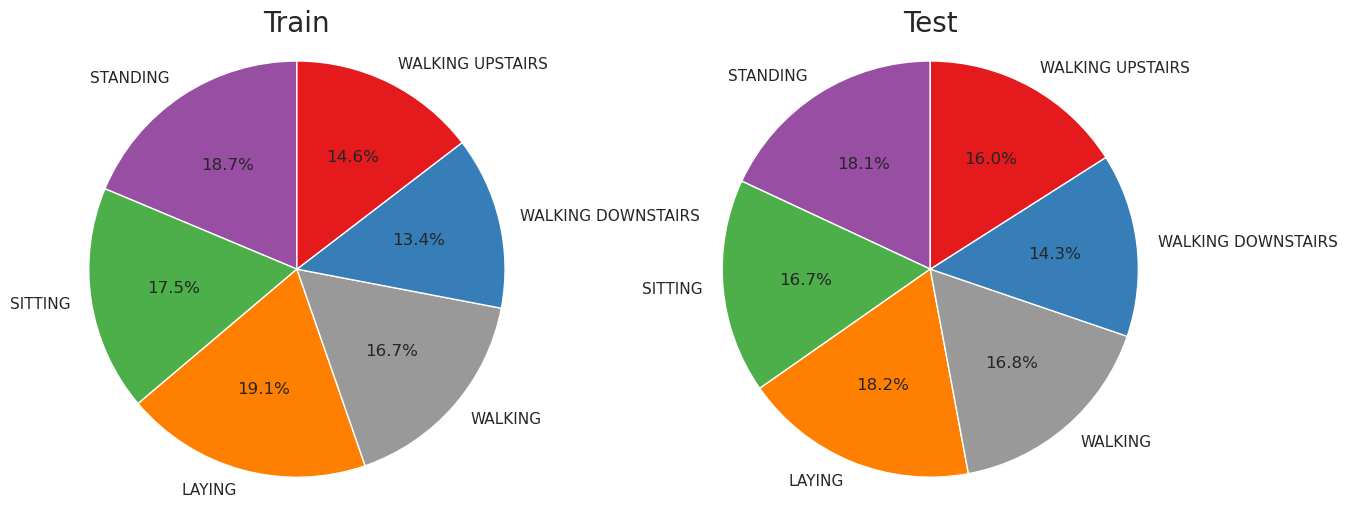

In [12]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,2,1)

ytrain_vc = collections.Counter(ytrain_label)
labels = ytrain_vc.keys()
colors = [COLOR_DIC[x] for x in labels]
sizes = [ytrain_vc[c] for c in labels]
ax.pie(sizes, labels=labels,colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title("Train", fontsize=20)

ax = fig.add_subplot(1,2,2)
ytest_vc = collections.Counter(ytest_label)
labels = ytest_vc.keys()
sizes = [ytest_vc[c] for c in labels]
colors = [COLOR_DIC[x] for x in labels]
ax.pie(sizes, labels=labels,colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title("Test", fontsize=20)

plt.show()

### Exploration 

The following code allows to display the results of the PCA on the features data. 

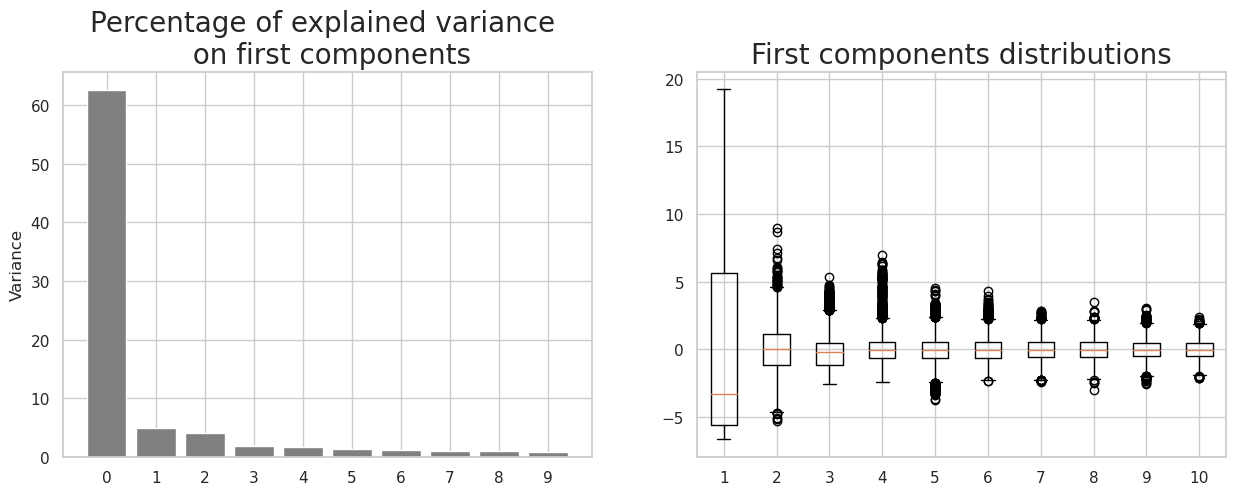

In [13]:
pca = sdec.PCA()
X_r = pca.fit_transform(XTrainFeatures)
fig = plt.figure(figsize=(15,5))
uil.plot_variance_acp(fig, pca, X_r)

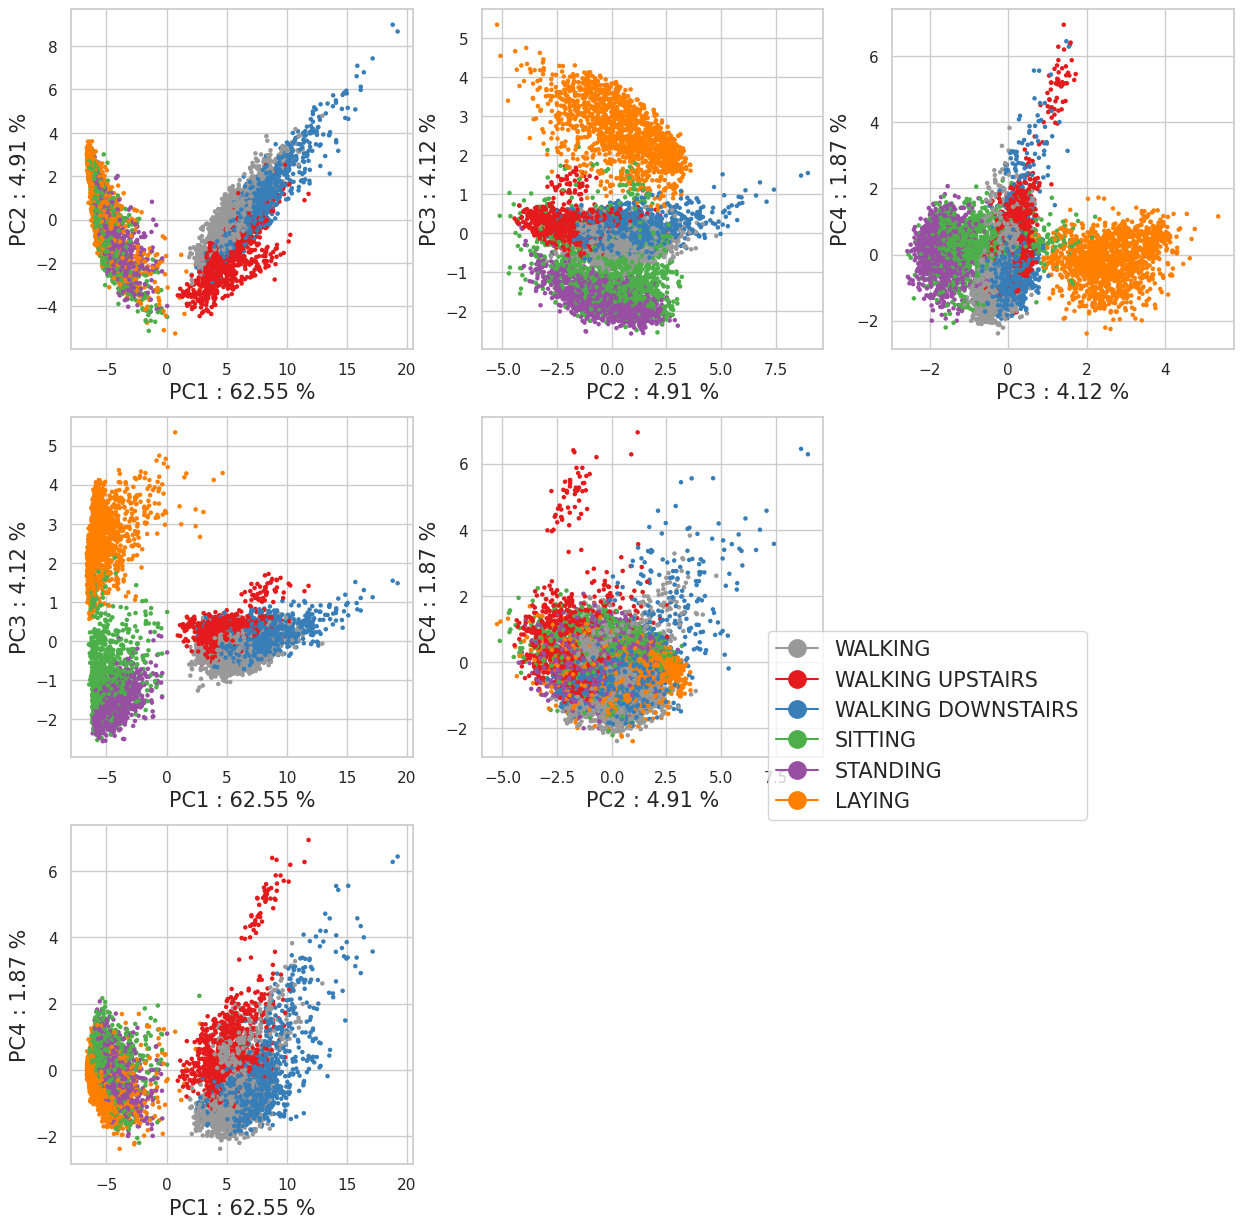

In [14]:
colors=[COLOR_DIC[y] for y in ytrain_label]
markersizes = [20 for y in ytrain]

fig = plt.figure(figsize= (15,15))
count = 0
for nbc, nbc2,count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax, X_r, pca, nbc, nbc2, colors, markersizes)

#Build legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=COLOR_DIC[act],marker=".", linestyle=None, markersize=25, label=act)for act in ACTIVITY_DIC.values()]
plt.legend(handles=legend_elements,loc='upper right', bbox_to_anchor=(3, 1.6),fontsize=15)
plt.show()

**Q** How is the PCA performing? How many components, among 561, would we need to describe the data?

**Q** Comment the separation you can see on the first axis

**Q** What can you say about the shape of the cloud?

**Q** What can you say about classes separation?

### Supervised classification  with the [logistic regression](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)

####  Principle 

The `Logistic Regression` is a very simple and classical statistical method for supervised classification,  but it is very effective on these features data. Logistic regression is suitable for predicting a binary variable. In the multiclass case, the logistic function of the `Scikit-learn` library estimates *by default* ** one model per class **: one class against the others.

The probability that one individual belongs to some class is modeled using a linear combination of the explanatory variables (features). To transform a real-valued linear combination  into a probability with values in the interval $ [0, 1] $, a sigmoidal function is applied. This gives :
$$P(y_i=1/X)=\frac{e^{Xb}}{1+e^{Xb}}$$
or equivalently
$$\log\frac{P(y_i=1/X)}{1-P(y_i=1/X)}=Xb.$$

The class affected to one individual is the one corresponding to the highest predicted probability. 

####  Estimation  of the model without optimization

The model is estimated without trying to refine the values of certain parameters (penalization). 

**NB** If you want to go further on the analysis of the features data, and study the performances of different algorithms such as  SVM,  discriminant analysis, $k$nearest neighbours, random forests, neural networks...see the corresponding notebook at `../data/HumanActivityRecognition/former_notebook`



Score : 0.957923, time running : 0 secondes


/usr/local/insa/anaconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:xlabel='Pred', ylabel='True'>

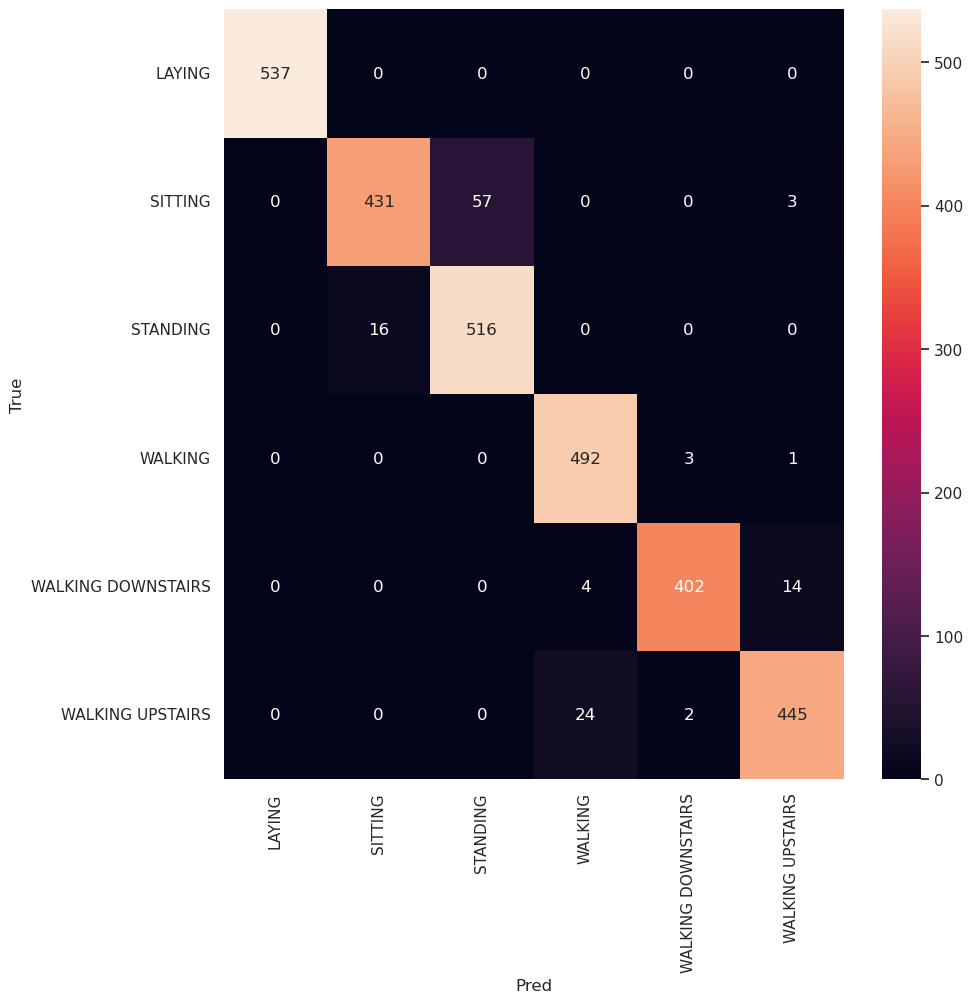

In [15]:
from sklearn.linear_model import LogisticRegression
ts = time.time()
method = LogisticRegression()
method.fit(XTrainFeatures,ytrain)
score = method.score(XTestFeatures, ytest)
ypred = method.predict(XTestFeatures)
ypred_label = np.array([ACTIVITY_DIC[y] for y in ypred])
te = time.time()

print("Score : %f, time running : %d secondes" %(score, te-ts))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sb.heatmap(pd.crosstab(np.array(ytest_label), ypred_label, rownames=['True'], colnames=['Pred']), annot=True, fmt="d")

**Q.** Comments the quality of the results. Are they coherent with the exploration stage?


## Raw Signals 

We will now try to achieve on the original signal data the same performance for the  classification as the one we got on the features data. We first read the data.

In [16]:
#Multidimensional Data
XTrainSignals, XTestSignals = ul.load_signals(DATA_PATH, "train", SIGNALS), ul.load_signals(DATA_PATH, "test", SIGNALS)
N_train, N_dim, N_signaux  = XTrainSignals.shape
N_test, _, _  = XTestSignals.shape
print("X Train data dimensions %d X %d X %d" %(XTrainSignals.shape))
print("X Test data dimensions %d X %d X %d" %(XTestSignals.shape))

X Train data dimensions 7352 X 128 X 9
X Test data dimensions 2947 X 128 X 9


Some of the studies we will produce on the data require the data to be 1-dimensional. This is  why we produce *flatten* data that will gather in a single vector the $9$ signals per individual and produce 1D vectors of size 128X9 = 1152. 

In [17]:
#Flatten_data
XTrainFlatten = XTrainSignals.reshape((N_train, N_dim*N_signaux), order="F")
XTestFlatten = XTestSignals.reshape((N_test, N_dim*N_signaux), order="F")
print("X Train data dimensions %d X %d" %(XTrainFlatten.shape))
print("X Test data dimensions %d X %d" %(XTestFlatten.shape))

X Train data dimensions 7352 X 1152
X Test data dimensions 2947 X 1152


### Visualize the signals

#### Display all signals

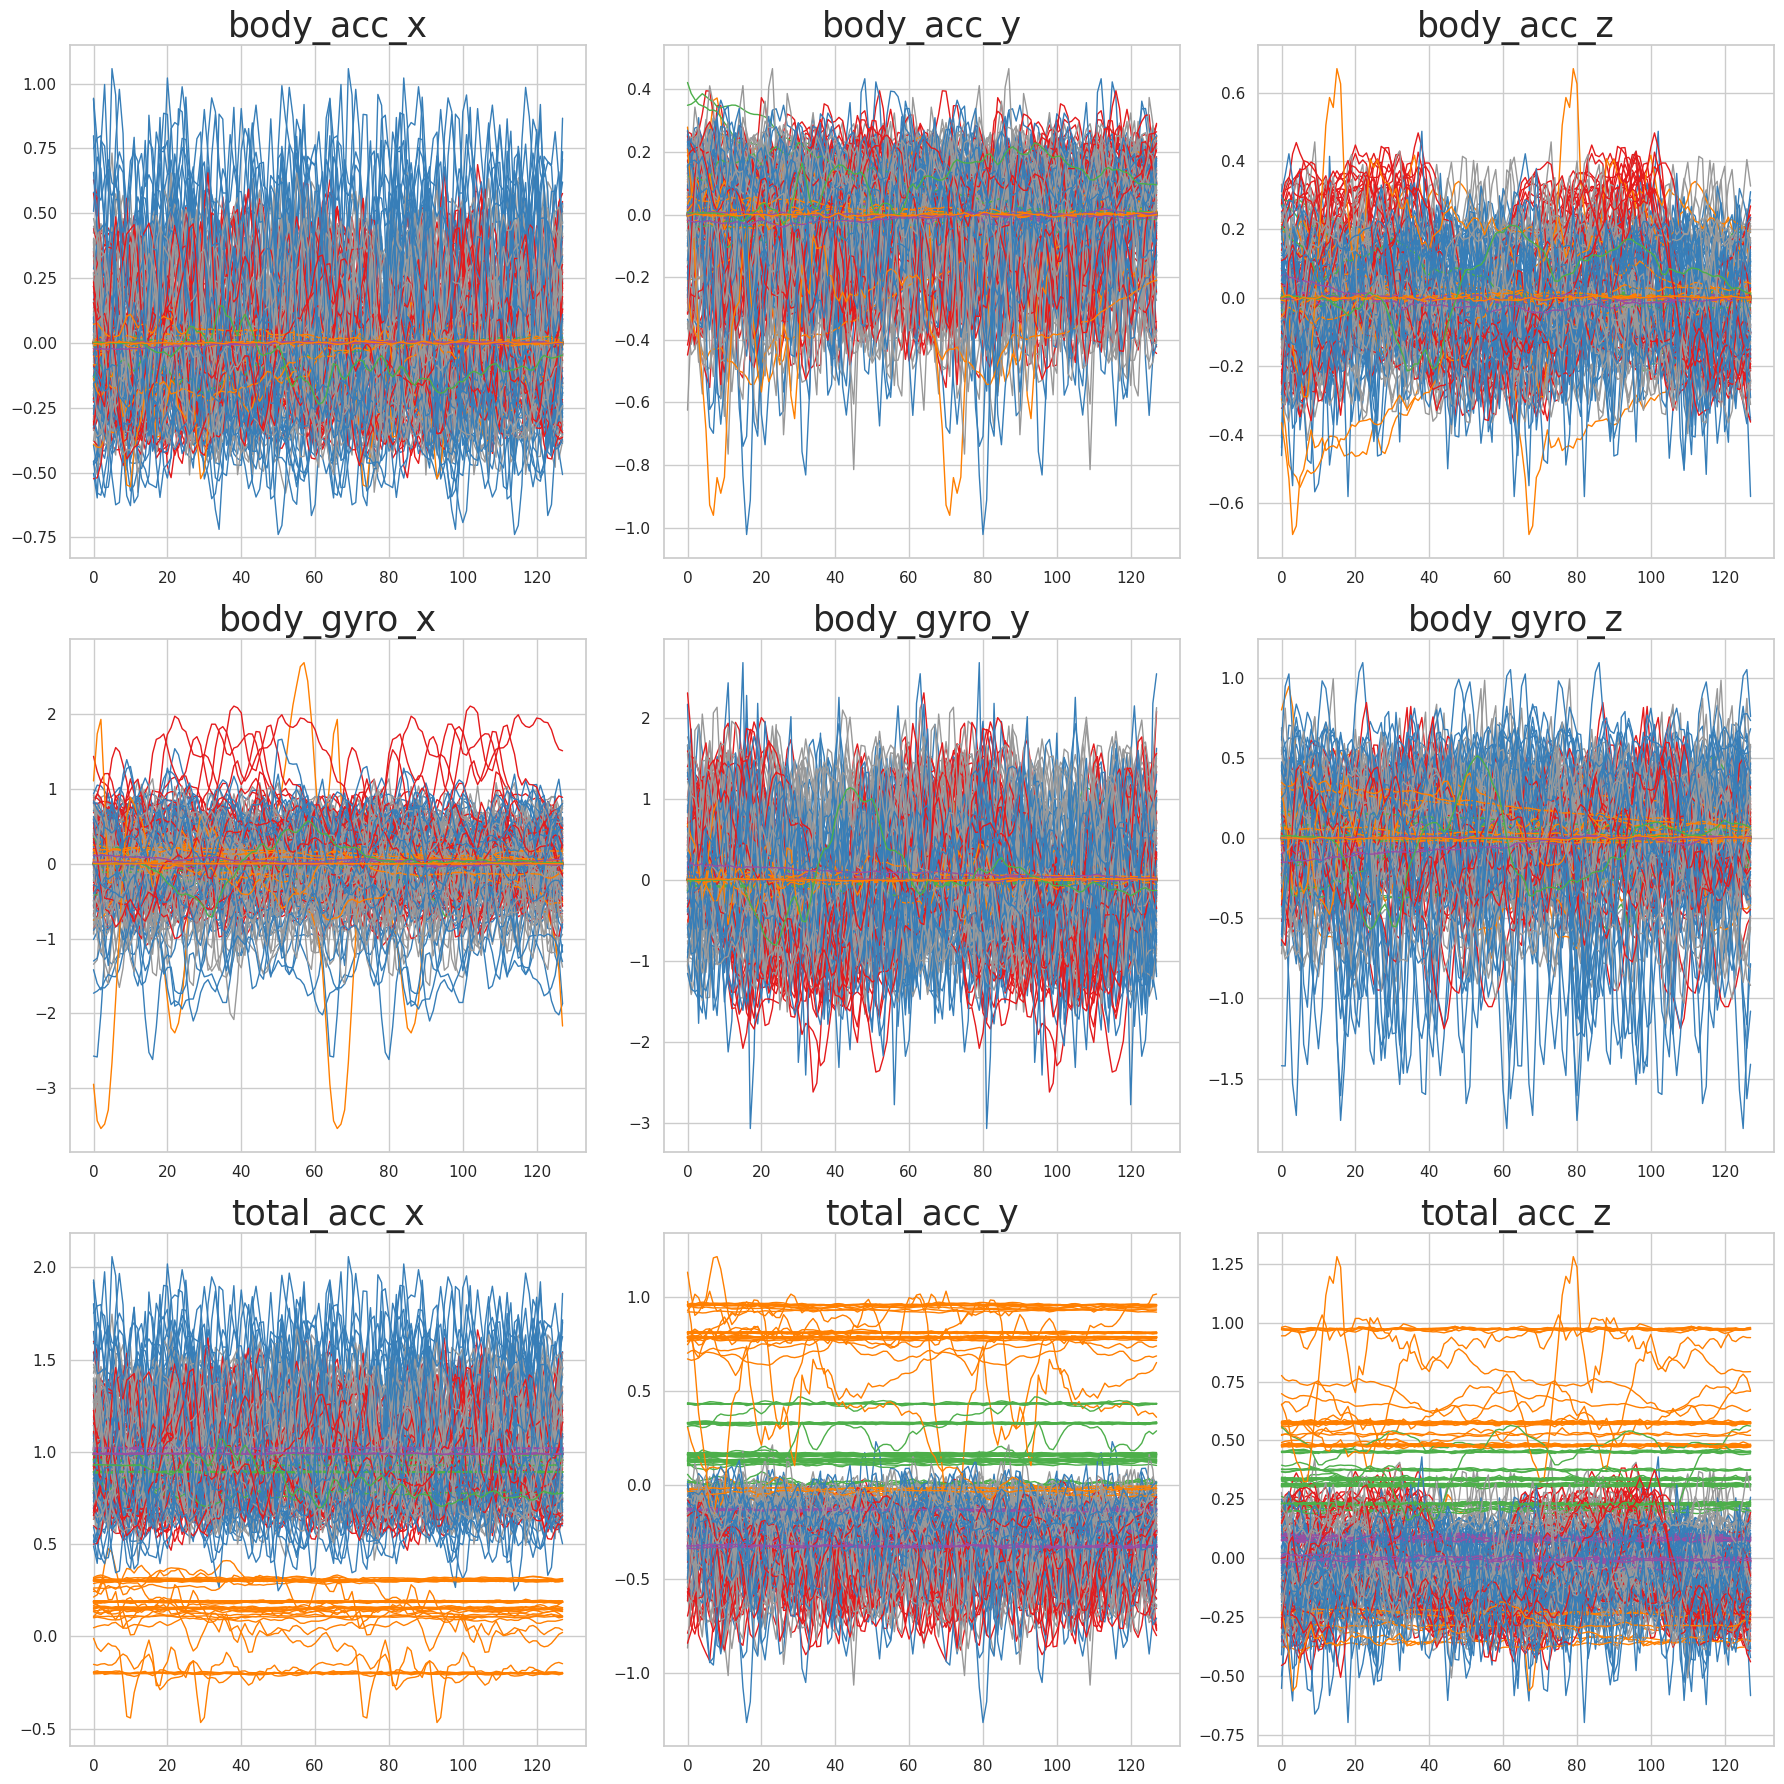

In [18]:
nb_sample_per_activity = dict([(v,50) for k,v in ACTIVITY_DIC.items()])
linestyle_per_activity = dict([(v,"solid") for k,v in ACTIVITY_DIC.items()])
linewidth_per_activity = dict([(v,1)for k,v in ACTIVITY_DIC.items()])

fig = plt.figure(figsize=(18,18))    
uil.plot_signaux(fig, XTrainSignals, np.array(ytrain_label), SIGNALS, COLOR_DIC, nb_sample_per_activity, 
             linestyle_per_activity, linewidth_per_activity, figdim1 = 3, figdim2 = 3, shuffle=True, legend=False)

#### Display only one signal
We only represent here the first signal (body acceleration in x), for the 6 classes, on $10$ individuals. 

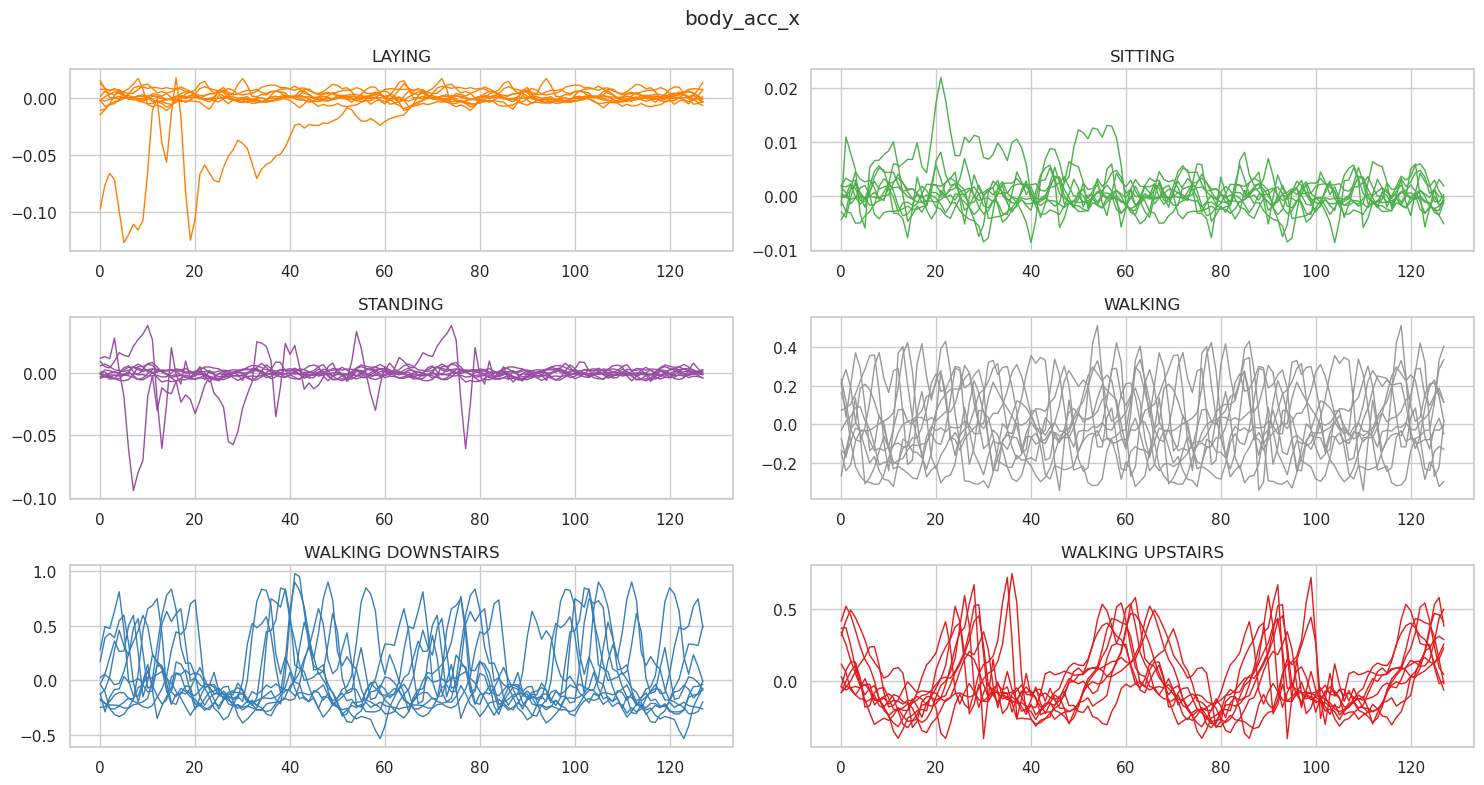

In [19]:
fig = plt.figure(figsize=(15,8))
nb_sample = 10
isignal=0    
uil.plot_signal_per_activity(fig, XTestSignals, ytest_label, nb_sample, isignal, SIGNALS, COLOR_DIC)

**Q** Choose one of the signal (Walking upstairs for example). What makes the Euclidean metric (L2) ineffective for this signal?

**Q** Why it is interesting to decompose the signal in the frequency domain in term of correlation?

### Exploration

####  Principal Components Analysis
##### On one signal

PCA on  signal : body_gyro_y


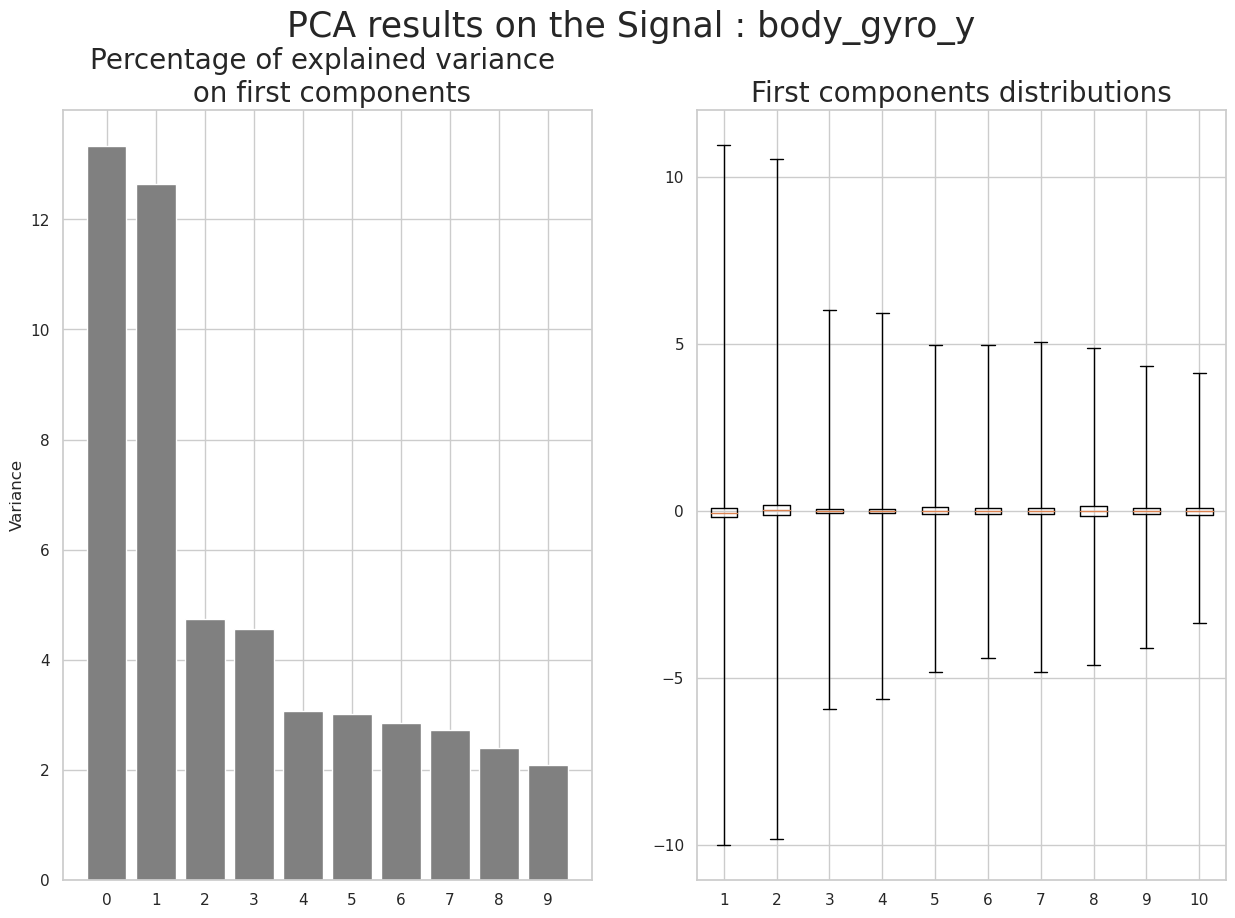

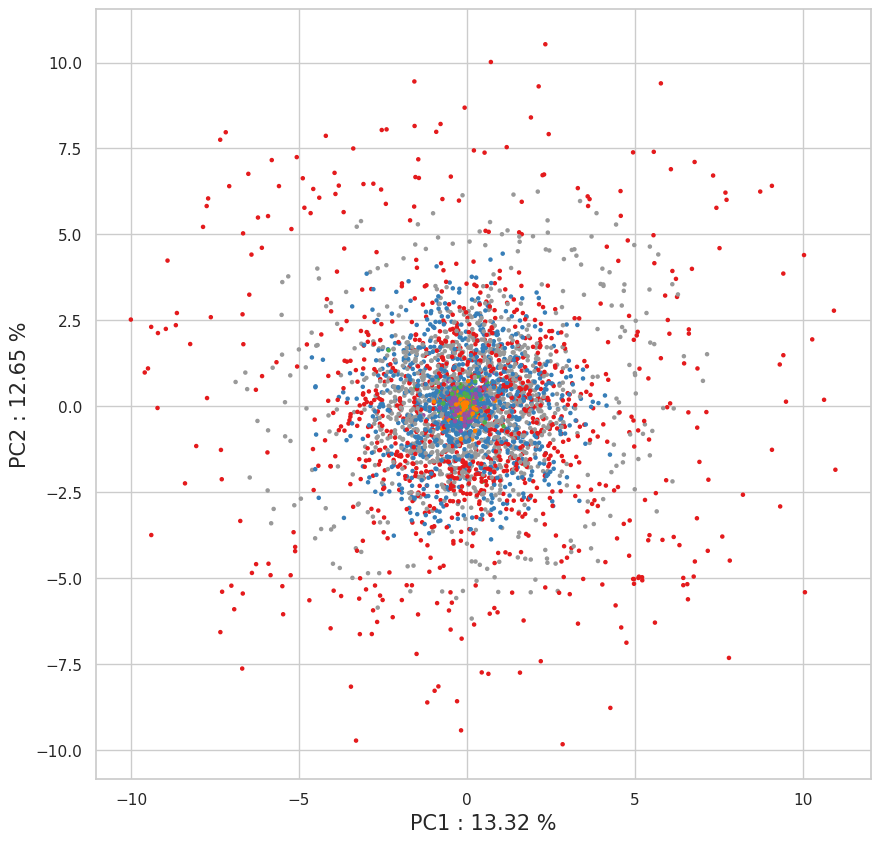

In [20]:
pca = sdec.PCA()
isignal = 4
signal = SIGNALS[isignal]
print("PCA on  signal : " +signal)
X_r = pca.fit_transform(XTrainSignals[:,:,isignal])

fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, pca, X_r, whis=100)
fig.suptitle(" PCA results on the Signal : " + signal, fontsize=25)

colors=[COLOR_DIC[y] for y in ytrain_label]
markersizes = [20 for _ in range(N_train)]
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
uil.plot_pca(ax,X_r, pca, 1, 2, colors, markersizes)

##### Over all signals

PCA on all the signals


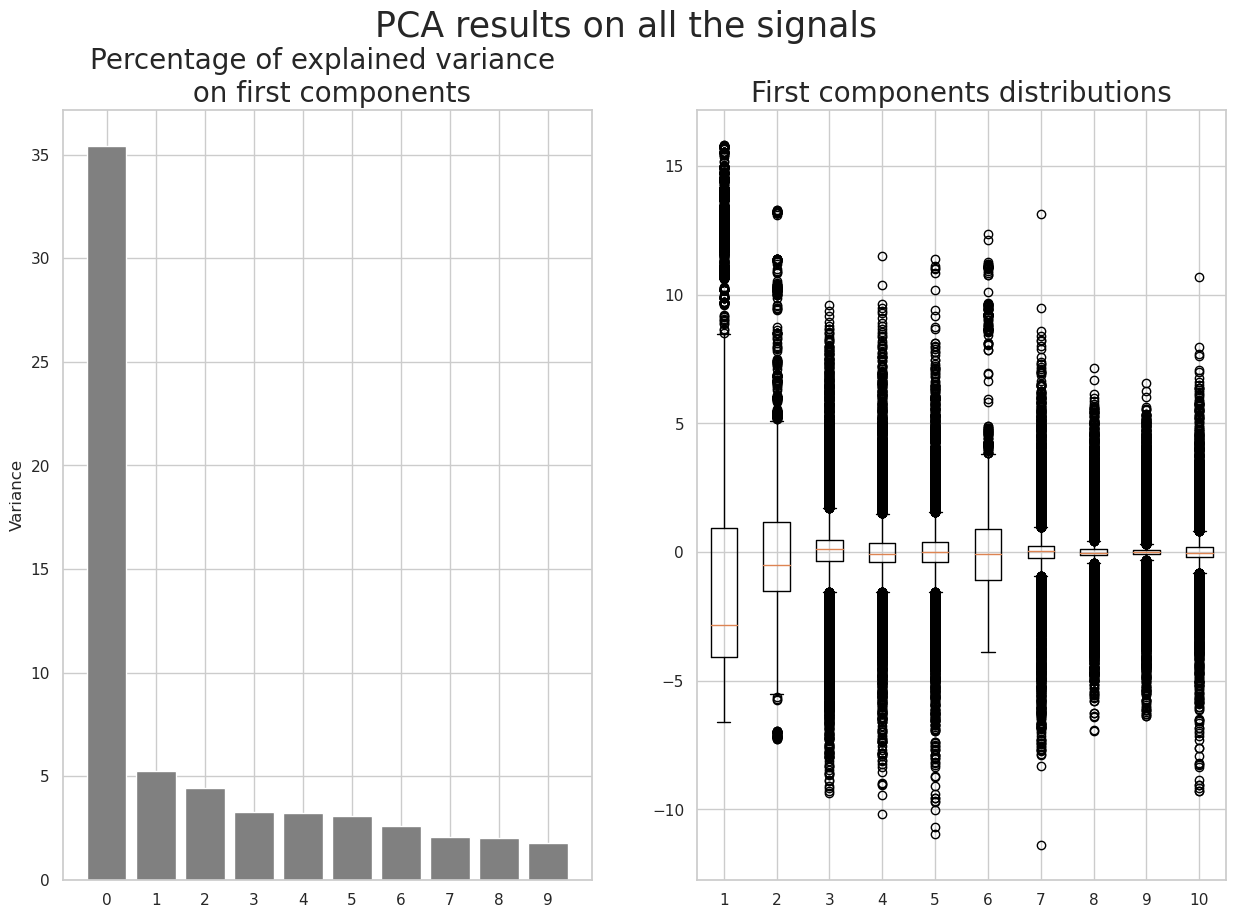

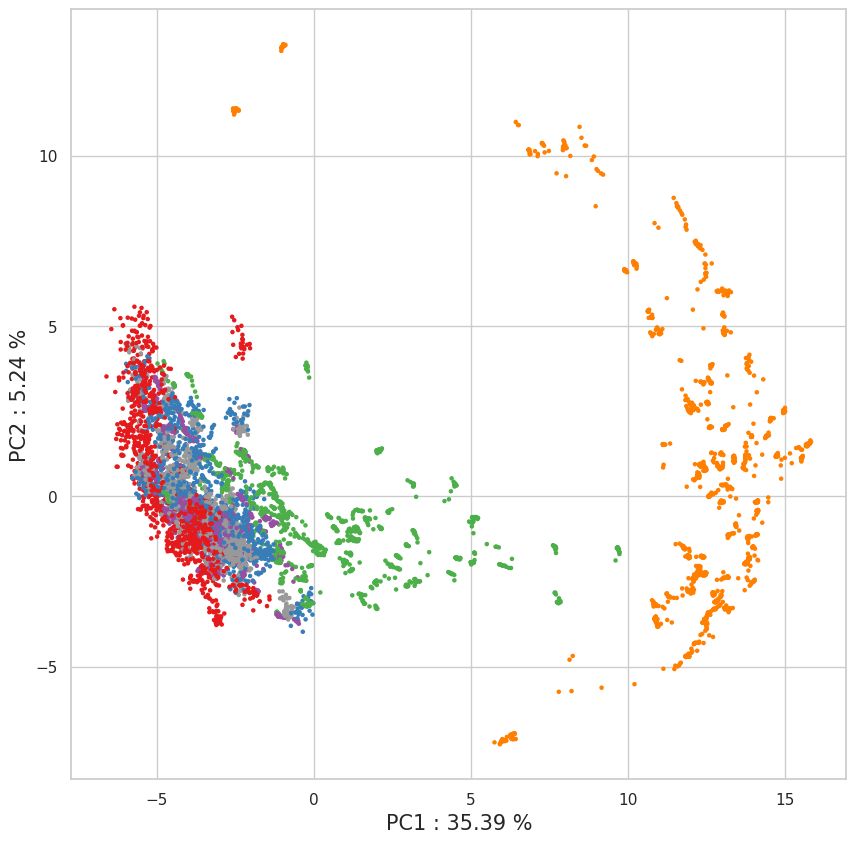

In [21]:
pca = sdec.PCA()
print("PCA on all the signals")
X_r = pca.fit_transform(XTrainFlatten)
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, pca, X_r)
fig.suptitle("PCA results on all the signals", fontsize=25)
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
uil.plot_pca(ax,X_r, pca, 1, 2, colors, markersizes)

#### Linear discriminant analysis
##### on one signal

LDA on  signal : body_acc_x


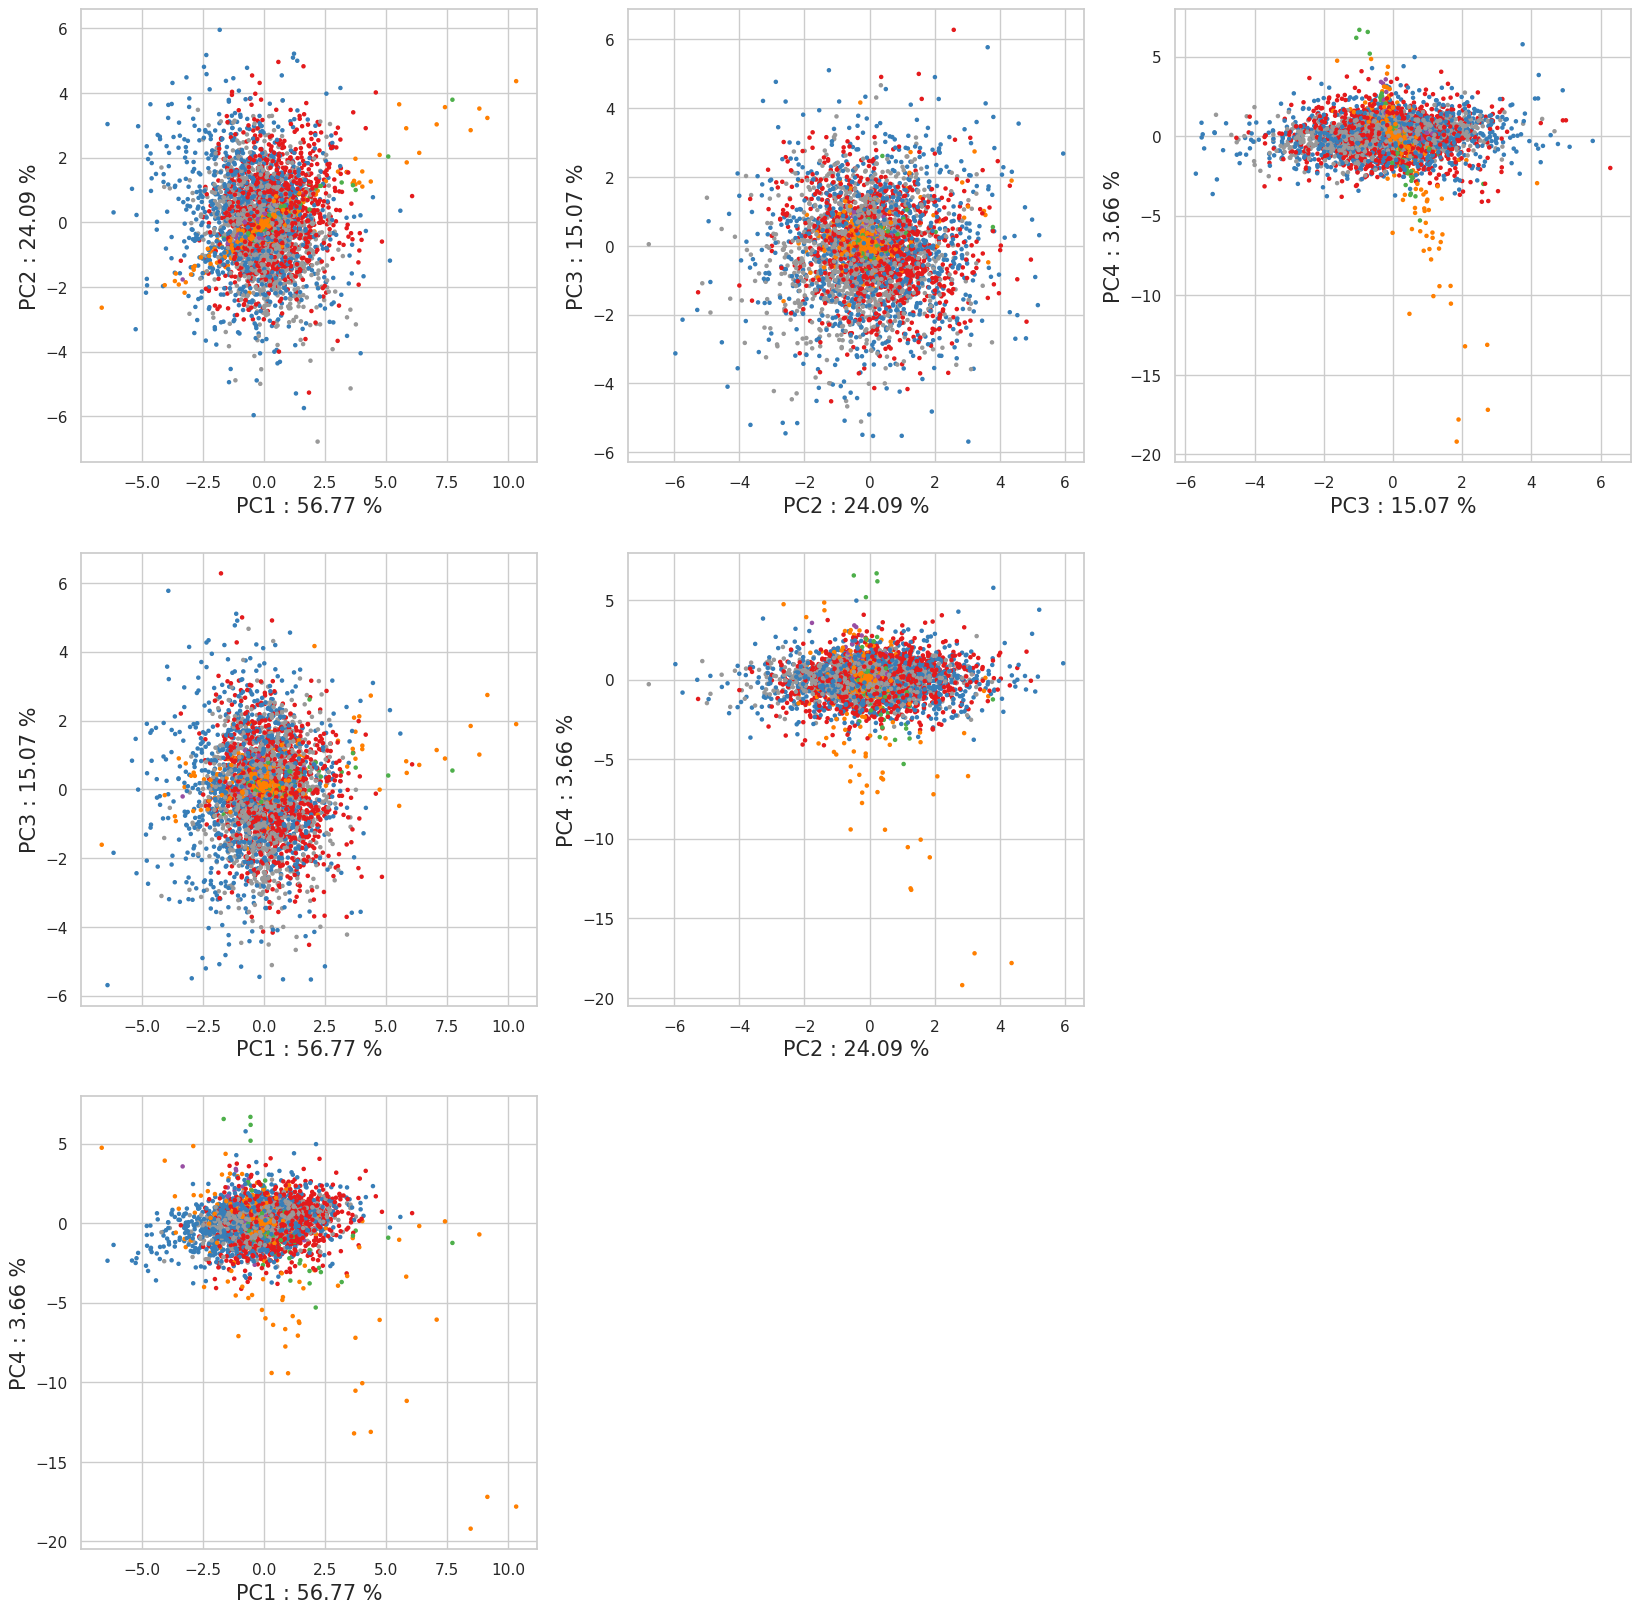

In [22]:
isignal = 0
signal = SIGNALS[isignal]
print("LDA on  signal : " +signal)

method = sda.LinearDiscriminantAnalysis() 
lda=method.fit(XTrainSignals[:,:,isignal],ytrain_label)
X_r2=lda.transform(XTrainSignals[:,:,isignal])

fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2, count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax,X_r2, lda, nbc, nbc2, colors, markersizes)
plt.show()

##### over all signals

LDA on all the signals


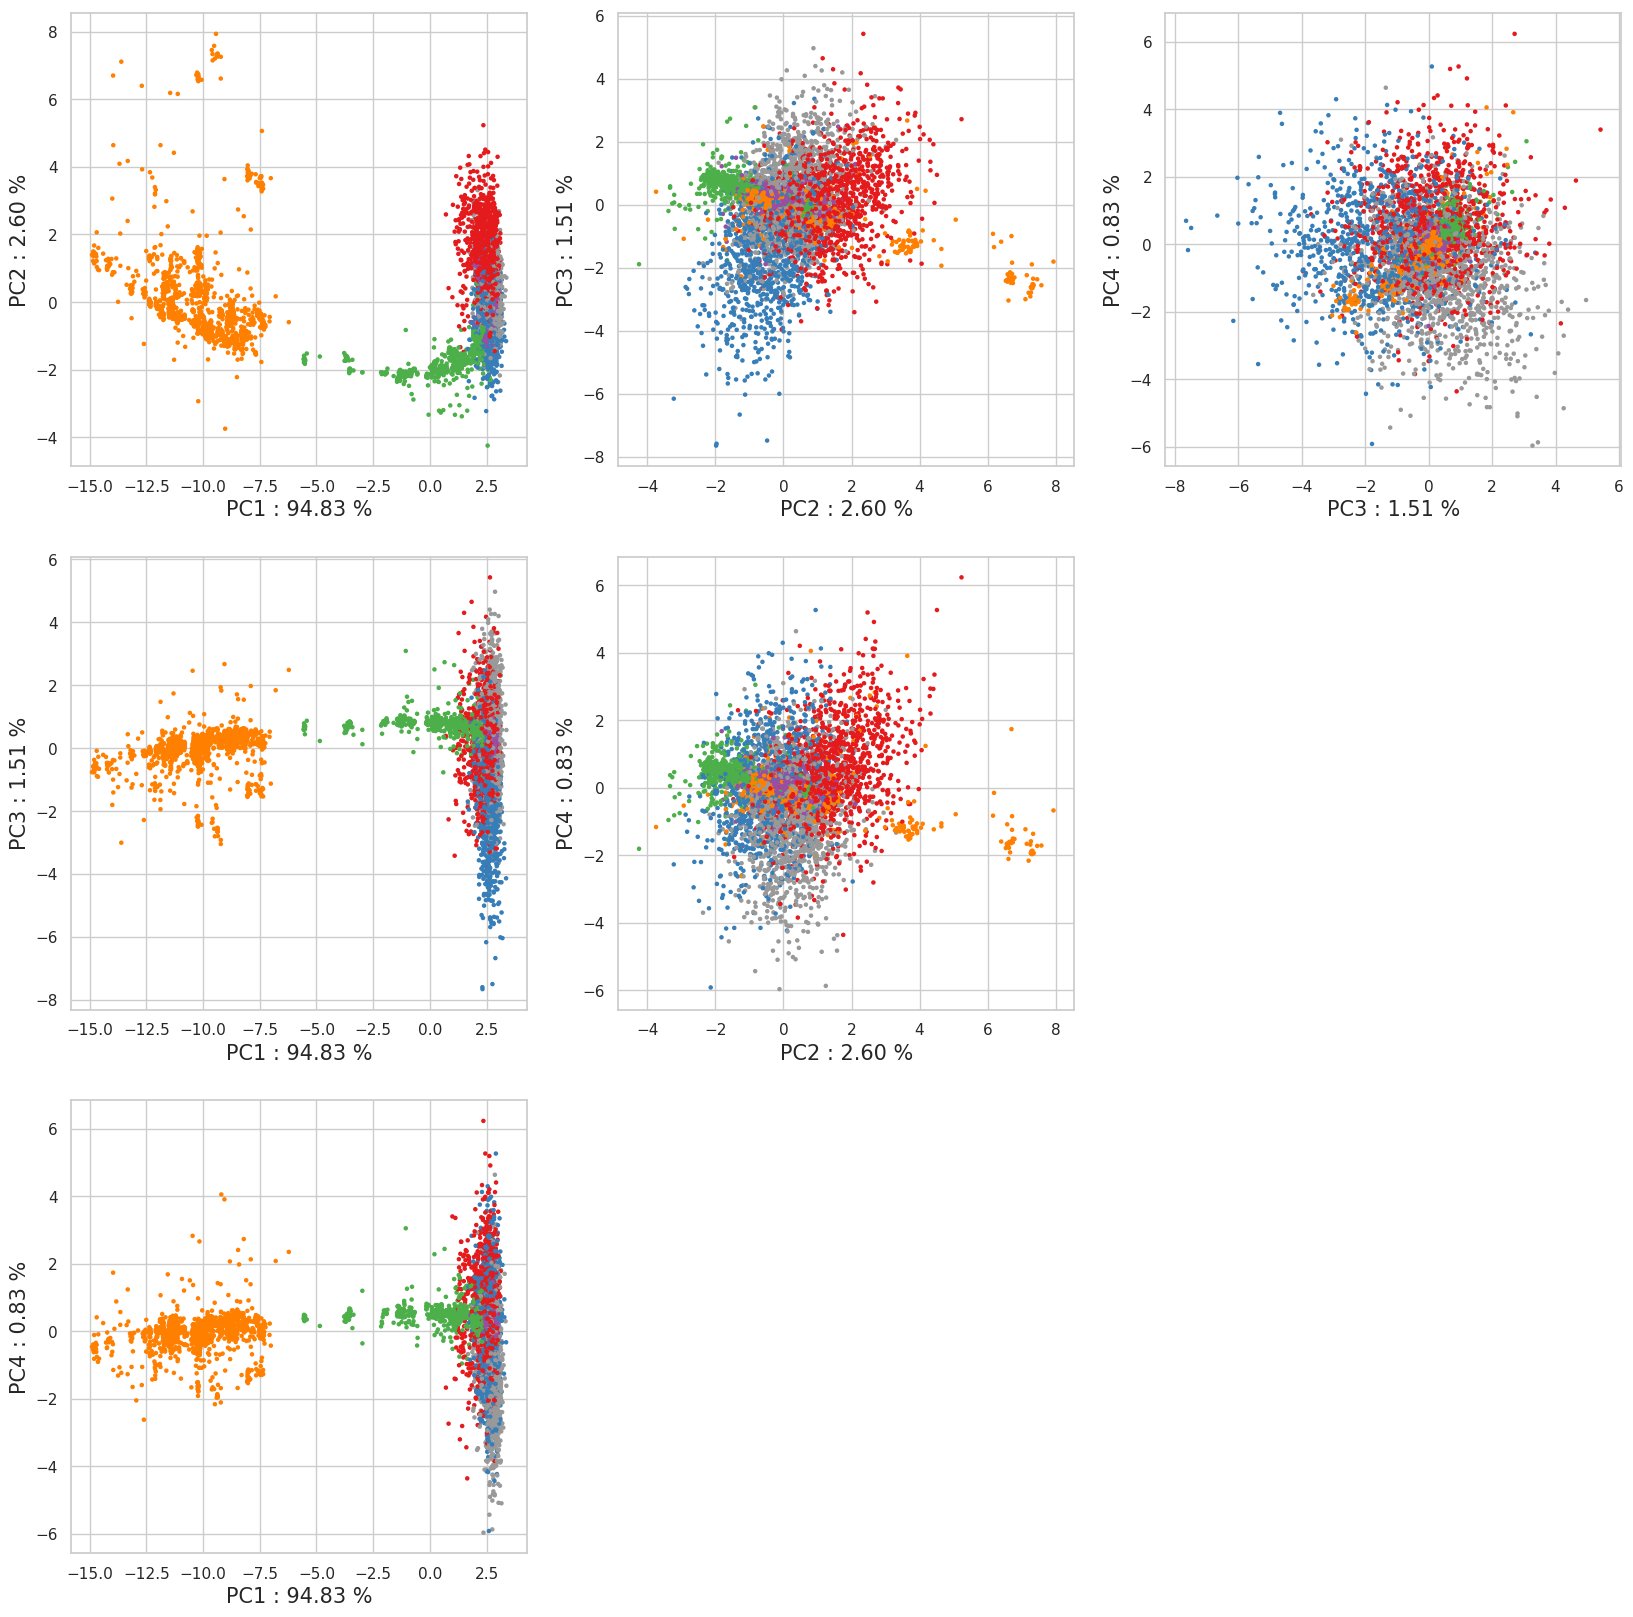

In [23]:
print("LDA on all the signals")

method = sda.LinearDiscriminantAnalysis() 
lda=method.fit(XTrainFlatten,ytrain_label)
X_r2=lda.transform(XTrainFlatten)

fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2, count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax,X_r2, lda, nbc, nbc2, colors, markersizes)
plt.show()

### Supervised classification with the logistic regression on the raw signals

Score : 0.569393, time running : 1 secondes


/usr/local/insa/anaconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:xlabel='Pred', ylabel='True'>

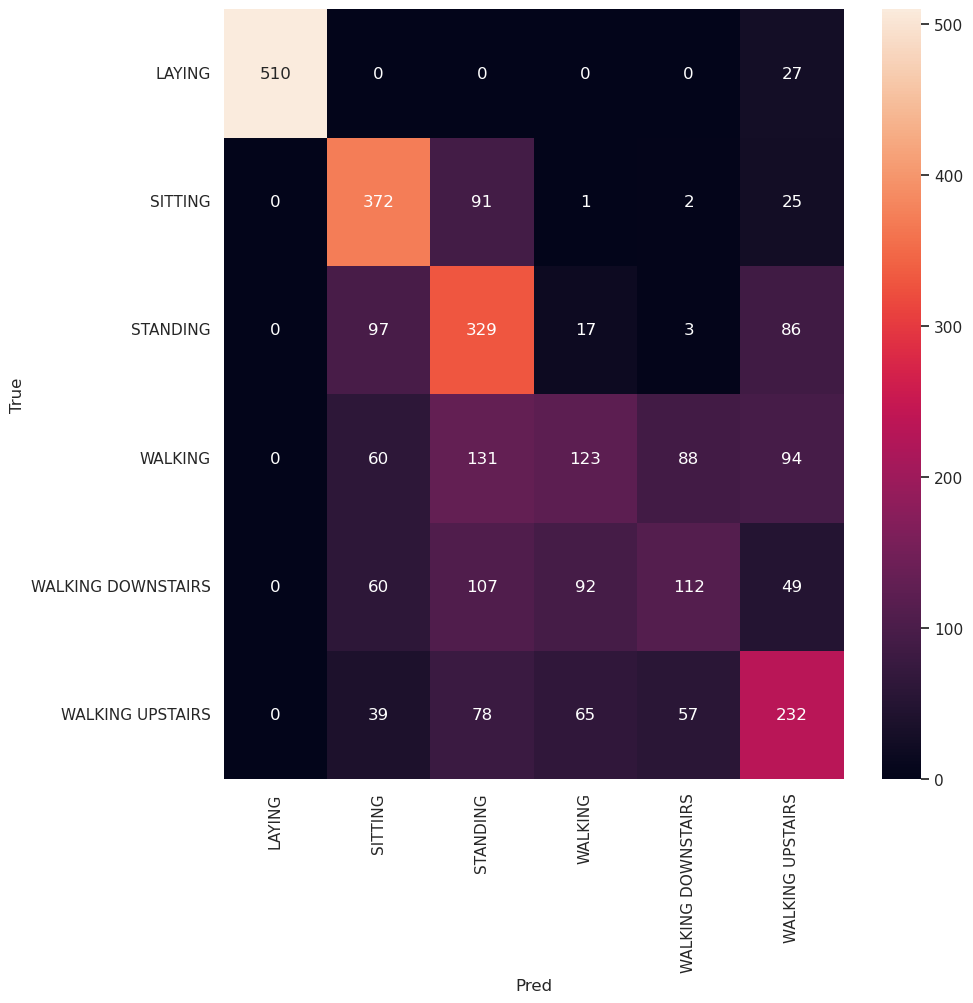

In [24]:
ts = time.time()
method = LogisticRegression()
method.fit(XTrainFlatten,ytrain)
score = method.score(XTestFlatten, ytest)
ypred = method.predict(XTestFlatten)
ypred_label = np.array([ACTIVITY_DIC[y] for y in ypred])
te = time.time()

print("Score : %f, time running : %d secondes" %(score, te-ts))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sb.heatmap(pd.crosstab(np.array(ytest_label), ypred_label, rownames=['True'], colnames=['Pred']), annot=True, fmt="d")

**Q** What can you say about these results?

**Exercise** If you have time at the end of the TP, try to achieve better results, using different models (SVM, Random Forest, Xgboost) of different combination of the signal

## Wavelet Decomposition of the raw signals

Since the supervised classification performed on the raw signal gives bad performances, we try to improve these results by transforming the raw signals with a wavelet decomposition. 

### Coefficient Illustration

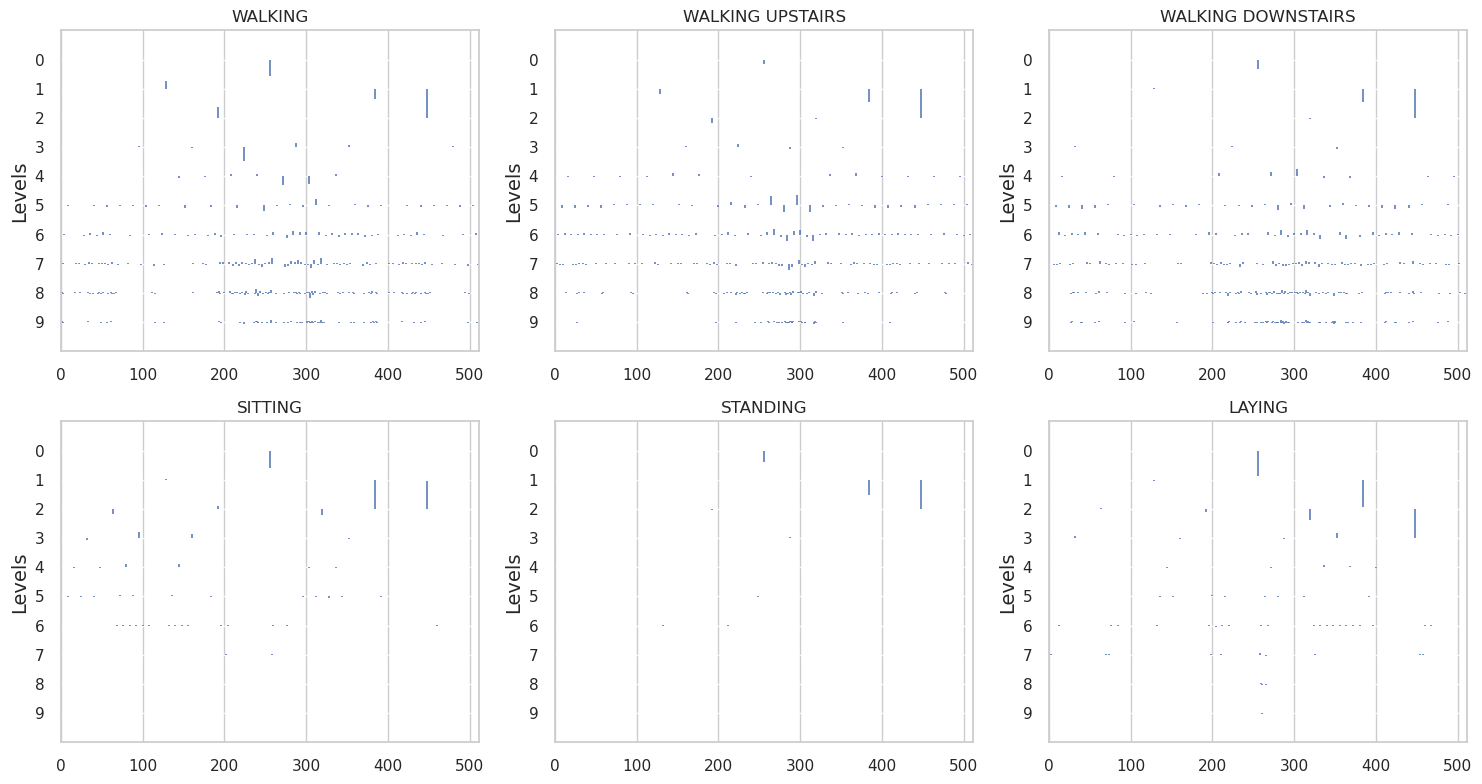

In [25]:
sample_to_plot = 1
index_per_act_dict = dict([(act, np.where(ytrain==act)[0][:sample_to_plot]) for act in range(1,7)])

fig = plt.figure(figsize=(15,8))
for ip, (act , index) in enumerate(index_per_act_dict.items()):
    ax=fig.add_subplot(2,3,ip+1)
    coef = pywt.wavedec(XTrainFlatten[index,:1024], 'db1')
    uil.coef_pyramid_plot(ax, coef[1:]) ;

    ax.set_title(ACTIVITY_DIC[act]);
fig.tight_layout()
plt.show()

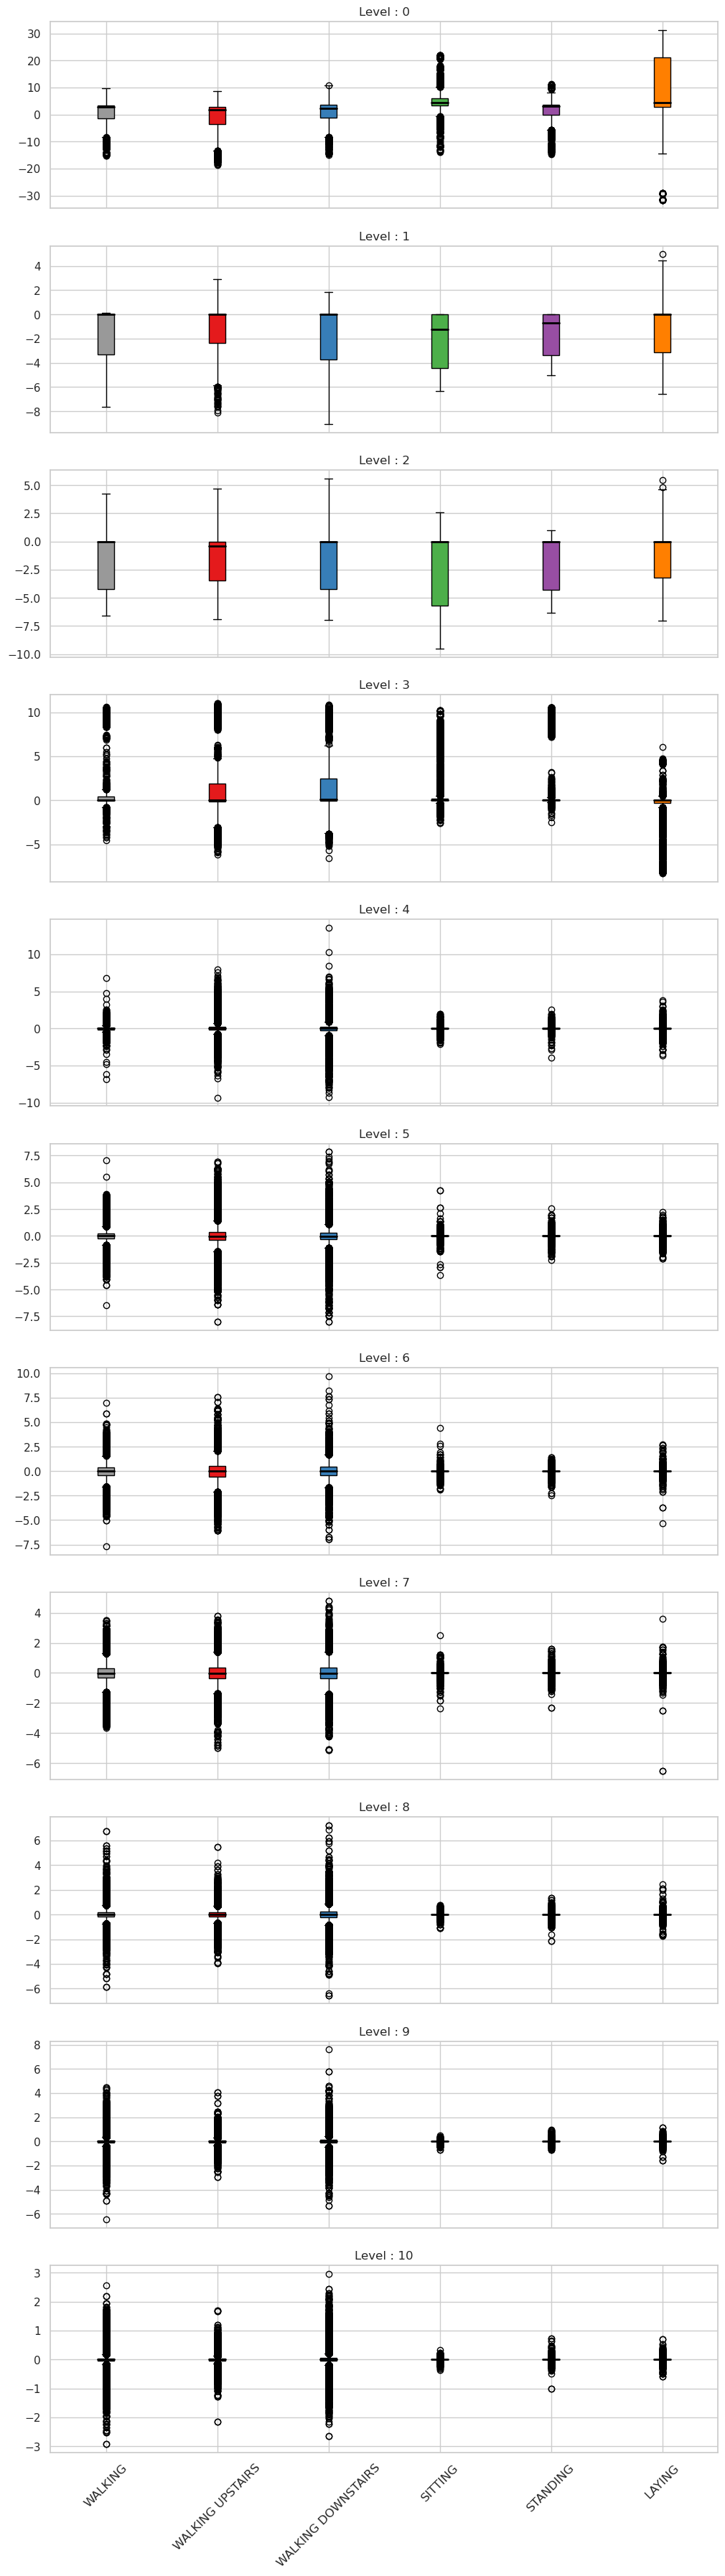

In [26]:
X_train_db_list = pywt.wavedec(XTrainFlatten, 'db1')
N_per_activity_train = collections.Counter(np.array(ytrain))
uil.plot_boxplot_coef_concat_per_signal(X_train_db_list, np.array(ytrain), labels=LABELS, activity_dic=ACTIVITY_DIC, 
                             color_dic=COLOR_DIC, N_per_activity_train= N_per_activity_train)

**Q.** Explain what is represented on all theses graphs. 

### Exploration of the wavelet coefficients

#### PCA on all the coefficients

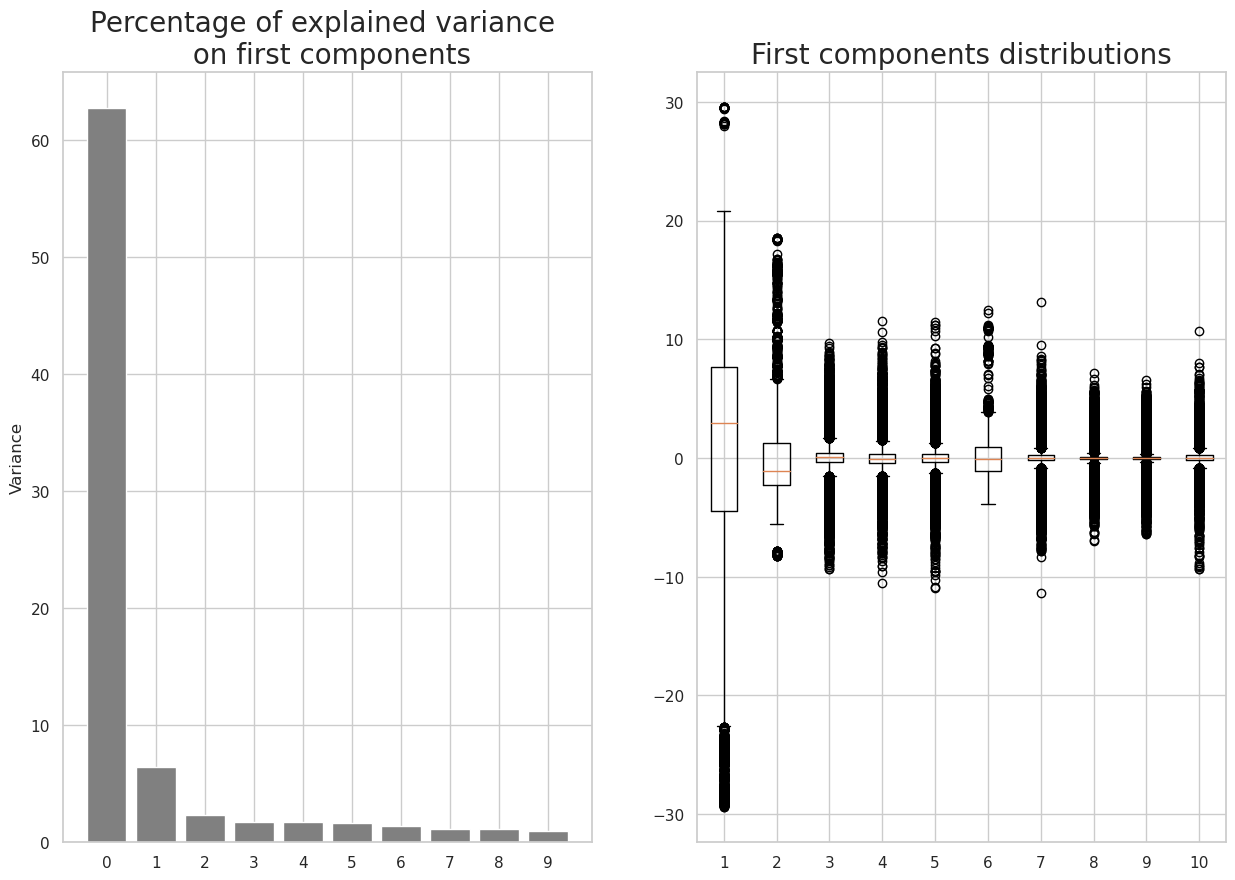

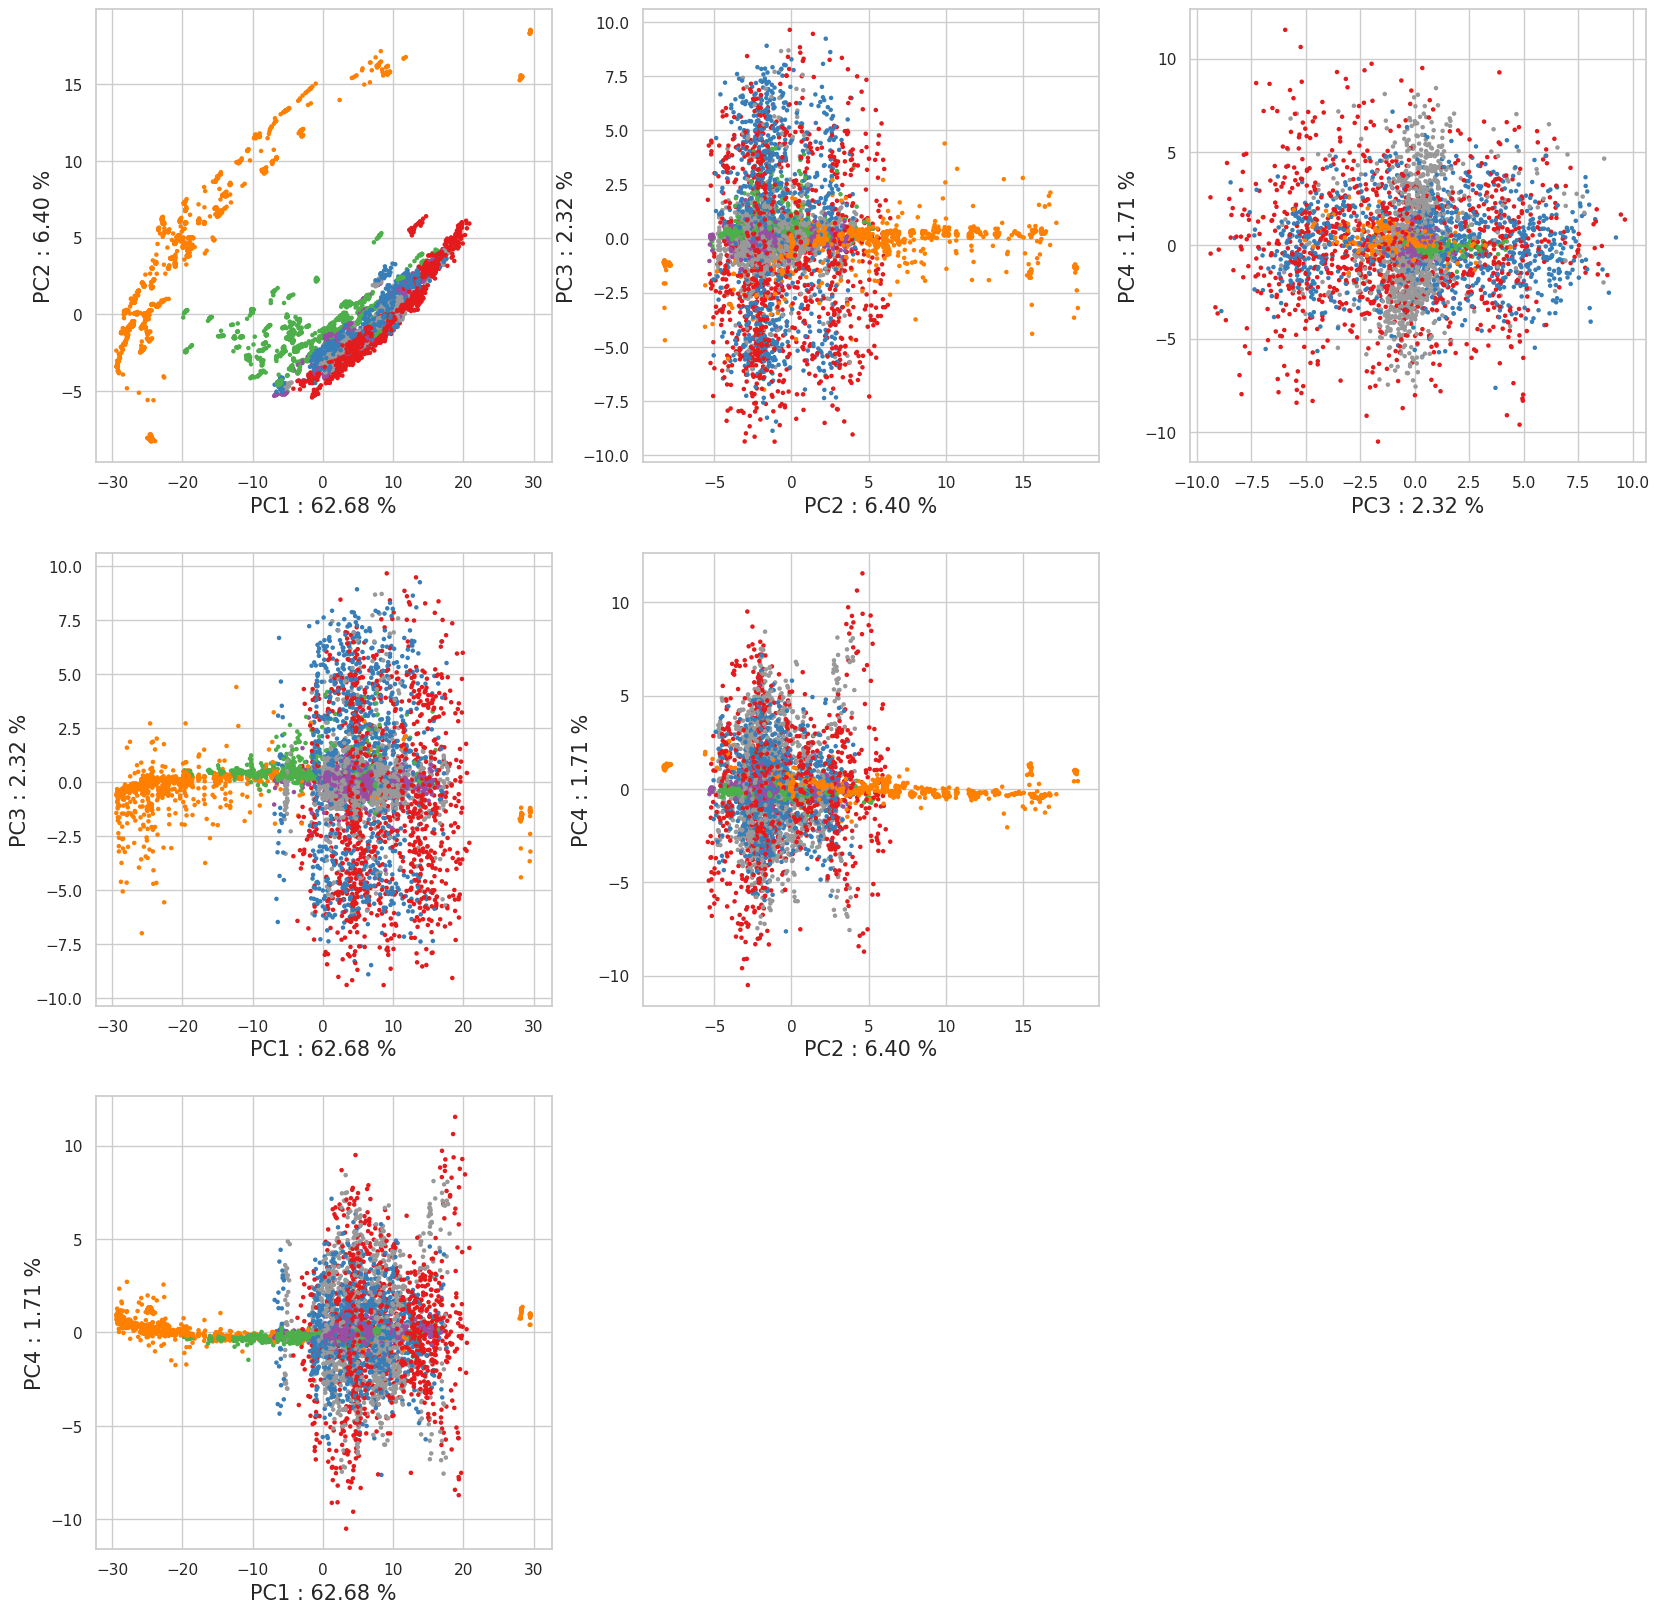

In [27]:
X_train_db = np.concatenate(pywt.wavedec(XTrainFlatten, 'db1'), axis=1)
X_test_db = np.concatenate(pywt.wavedec(XTestFlatten, 'db1'), axis=1)

## PCA 
pca = sdec.PCA()
X_train_db_pca = pca.fit_transform(X_train_db)

fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, pca, X_train_db_pca)

fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2, count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax,X_train_db_pca, pca, nbc, nbc2, colors, markersizes)
plt.show()

#### On the thresholded coefficients

We use a soft thresholding on the wavelet coefficients in order to remove some noise from the data.

In [28]:
cA10, cD10, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(XTrainFlatten, 'db1')

sigma=0.01
thresh = sigma*np.sqrt(2*np.log((XTrainFlatten.shape[1])))

# On seuille seulement les coefficients de détail : 
cD10=pywt.threshold(cD10, thresh, 'soft')
cD9=pywt.threshold(cD9, thresh, 'soft')
cD8=pywt.threshold(cD8, thresh, 'soft')
cD7=pywt.threshold(cD7, thresh, 'soft')
cD6=pywt.threshold(cD6, thresh, 'soft')
cD5=pywt.threshold(cD5, thresh, 'soft')
cD4=pywt.threshold(cD4, thresh, 'soft')
cD3=pywt.threshold(cD3, thresh, 'soft')
cD2=pywt.threshold(cD2, thresh, 'soft')
cD1=pywt.threshold(cD1, thresh, 'soft')

X_train_dbth = np.concatenate((cA10, cD10, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1), axis=1)

In [29]:
cA10, cD10, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(XTestFlatten, 'db1')

sigma=0.01
thresh = sigma*np.sqrt(2*np.log((XTestFlatten.shape[1])))

# On seuille seulement les coefficients de détail : 
cD10=pywt.threshold(cD10, thresh, 'soft')
cD9=pywt.threshold(cD9, thresh, 'soft')
cD8=pywt.threshold(cD8, thresh, 'soft')
cD7=pywt.threshold(cD7, thresh, 'soft')
cD6=pywt.threshold(cD6, thresh, 'soft')
cD5=pywt.threshold(cD5, thresh, 'soft')
cD4=pywt.threshold(cD4, thresh, 'soft')
cD3=pywt.threshold(cD3, thresh, 'soft')
cD2=pywt.threshold(cD2, thresh, 'soft')
cD1=pywt.threshold(cD1, thresh, 'soft')

X_test_dbth = np.concatenate((cA10, cD10, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1), axis=1)

In [ ]:
## PCA
pca = sdec.PCA()
X_train_dbth_pca = pca.fit_transform(X_train_dbth)
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, pca, X_train_db_pca)
fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2, count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax,X_train_dbth_pca, pca, nbc, nbc2, colors, markersizes)
plt.show()

**Q.** Comment the results. Does the thresholding seem to have an influence ? You can change the value of sigma. 

### Supervised classification with the logistic regression on the wavelet coefficients

In [ ]:
ts = time.time()
method = LogisticRegression()
method.fit(X_train_dbth,ytrain)
score = method.score(X_test_dbth, ytest)
ypred = method.predict(X_test_dbth)
ypred_label = np.array([ACTIVITY_DIC[y] for y in ypred])
te = time.time()

print("Score : %f, time running : %d secondes" %(score, te-ts))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sb.heatmap(pd.crosstab(np.array(ytest_label), ypred_label, rownames=['True'], colnames=['Pred']), annot=True, fmt="d")

**Q.** Compare with the results obtained on the raw data and on the features data. 

## Fast Fourier Transform

Since the wavelet decomposition did not allow to obtain good classification results, we now consider Fourier coefficients. 

In [ ]:
# Coefficients fft : 

from scipy.fftpack import fft


isignal = 0

XTrain_fftCoeff = []

for x in XTrainFlatten :
    
    mx=np.mean(x)
    x_centre=x-mx
   #Apply fast Fourier transform
    coeffsfft=np.abs(fft(x_centre))  
    coeffsfft_flatten = np.hstack(coeffsfft)
    XTrain_fftCoeff.append(coeffsfft_flatten)
        
XTrain_fftCoeff = np.array(XTrain_fftCoeff)

# Il suffit de garder la moitié des coefficients (ils sont ensuite répétés  de manière symétrique)

XTrain_fftCoeff=XTrain_fftCoeff[:,:64]
print(XTrain_fftCoeff.shape)

In [ ]:
isignal = 0

XTest_fftCoeff = []

for x in XTestFlatten :
    
    mx=np.mean(x)
    x_centre=x-mx
   #Apply fast Fourier transform
    coeffsfft=np.abs(fft(x_centre))  
    coeffsfft_flatten = np.hstack(coeffsfft)
    XTest_fftCoeff.append(coeffsfft_flatten)
        
XTest_fftCoeff = np.array(XTest_fftCoeff)


XTest_fftCoeff=XTest_fftCoeff[:,:64]
print(XTest_fftCoeff.shape)


### PCA for FFT  coefficients 

In [ ]:

## PCA 
pca = sdec.PCA()
X_train_fftCoeff_pca = pca.fit_transform(XTrain_fftCoeff)

fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, pca, X_train_fftCoeff_pca)

fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2, count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    uil.plot_pca(ax,X_train_fftCoeff_pca, pca, nbc, nbc2, colors, markersizes)
plt.show()

**Q.** Comment the results. Which classes are well separated on the first plane of the PCA ? 

### Supervised classification with the logistic regression on the FFT coefficients

In [ ]:
ts = time.time()
method = LogisticRegression()
method.fit(XTrain_fftCoeff,ytrain)
score = method.score(XTest_fftCoeff, ytest)
ypred = method.predict(XTest_fftCoeff)
ypred_label = np.array([ACTIVITY_DIC[y] for y in ypred])
te = time.time()

print("Score : %f, time running : %d secondes" %(score, te-ts))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sb.heatmap(pd.crosstab(np.array(ytest_label), ypred_label, rownames=['True'], colnames=['Pred']), annot=True, fmt="d")

**Q.** Compare these results with the ones obtained with wavelet coefficients. 

## Multilayer perceptrons and  Convolutional Neural Networks

We try here to improve the classification results by applying multilayer perceptrons and  convolutional neural networks on the raw signals. 

As explained in the introduction, calculating many transformations of the data such as the features used in the first part is too resource-consuming for the battery of a connected smartphone. This section proposes to use only the raw signals to train a neural network that could be "wired" in the circuit. Indeed an algorithm such as XGBoost (extreme gradient boosting) also achieves good results on raw signals but at a too high algorithmic cost.

Three algorithms are successively tested: a multilayer perceptron, followed by a 1D convolutional neural network on the flatten signals, and finally a 2D convolutional neural network on the 9 signals.

It should be added that many configurations have been tested, thanks  to the students of INSA Toulouse of the  Applied Mathematics - Data Science speciality, before adopting the ones proposed here. It is a reality of deep learning, without  precise theoretical results, only an experimental  approach  allows to determine a more efficient configuration. Other network architectures would have to be tested to reach the 96% of the previous solution.

**Q.** In each case, describe the model that is used, explain the number of parameters of the model and comment the performances. 

In [ ]:
# DEEP LEARNING libraries
import tensorflow as tf
import tensorflow.keras.models as km 
import tensorflow.keras.layers as kl 

### MLP on unidimensional data

In [ ]:
epochs = 10
batch_size = 32
n_features = XTrainFlatten.shape[1]
n_classes=6


**Q.** Build a multilayer perceptron named "model_base_mlp_u", with the following layers : 

  * a dense layer with 32 neurons and activation function relu
  * a dropout layer with a dropout probability equal to 0.5 
  * the output layer is a dense layer with 6 neurons and the softmax activation function 
  
  Print the summary of the model. Retrieve the number of parameters and the output shape of each layer of the model. 
  

In [ ]:
# %load solutions/dense1D.py
# MLP on unidimensional data
n_hidden = 32
model_base_mlp_u =km.Sequential()
model_base_mlp_u.add(kl.Dense(n_hidden, input_shape=(n_features,),  activation = "relu"))
model_base_mlp_u.add(kl.Dropout(0.5))
model_base_mlp_u.add(kl.Dense(n_classes, activation='softmax'))
model_base_mlp_u.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_base_mlp_u.summary()


In [ ]:
t_start = time.time()
model_base_mlp_u.fit(XTrainFlatten,  ytrain-1, batch_size=batch_size, validation_data=(XTestFlatten, ytest-1), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_mlp_u.evaluate(XTestFlatten,ytest-1)[1] 
print("Score With Simple MLP on Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_mlp_u = {"time_learning" : t_learning, "score" : score}
base_mlp_u_prediction = model_base_mlp_u.predict(XTestFlatten)
y_pred_label = [ACTIVITY_DIC[x] for x in base_mlp_u_prediction.argmax(axis=1)+1]

print("Score : %f, time running : %d secondes" %(score, te-ts))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sb.heatmap(pd.crosstab(np.array(ytest_label), ypred_label, rownames=['True'], colnames=['Pred']), annot=True, fmt="d")

### On multi-dimensional signals

#### MLP

In [ ]:
n_hidden = 50
timesteps = len(XTrainSignals[0])
input_dim = len(XTrainSignals[0][0])
n_classes = 6

model_base_mlp =km.Sequential()
model_base_mlp.add(kl.Dense(n_hidden, input_shape=(timesteps, input_dim),  activation = "relu"))
model_base_mlp.add(kl.Reshape((timesteps*n_hidden,) , input_shape= (timesteps, n_hidden)  ))
model_base_mlp.add(kl.Dense(n_classes, activation='softmax'))

model_base_mlp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_base_mlp.summary()

**Q.** Retrieve the number of parameters and the output shape of each layer of the model. 

In [ ]:
t_start = time.time()
model_base_mlp.fit(XTrainSignals,  ytrain-1, batch_size=batch_size, validation_data=(XTestSignals, ytest-1), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_mlp.evaluate(XTestSignals, ytest-1)[1] 
print("Score With Simple MLP on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_mlp = {"time_learning" : t_learning, "score" : score}
base_mlp_prediction = model_base_mlp.predict(XTestSignals)

y_pred_label = [ACTIVITY_DIC[x] for x in base_mlp_prediction.argmax(axis=1)+1]

print("Score : %f, time running : %d secondes" %(score, te-ts))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sb.heatmap(pd.crosstab(np.array(ytest_label), ypred_label, rownames=['True'], colnames=['Pred']), annot=True, fmt="d")

#### 1D Convolutional neural network

In [ ]:
model_base_conv_1D =km.Sequential()
model_base_conv_1D.add(kl.Conv1D(32, 5, activation='relu', input_shape=(timesteps, input_dim)))
model_base_conv_1D.add(kl.MaxPooling1D(pool_size=3))
model_base_conv_1D.add(kl.Flatten())
model_base_conv_1D.add(kl.Dense(n_classes, activation='softmax'))
model_base_conv_1D.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_base_conv_1D.summary()

**Q.** Retrieve the number of parameters and the output shape of each layer of the model and understand how the 1D convolution acts on the signals.


In [ ]:
t_start = time.time()
model_base_conv_1D.fit(XTrainSignals,  ytrain-1, batch_size=batch_size, validation_data=(XTestSignals, ytest-1), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_conv_1D.evaluate(XTestSignals, ytest-1)[1] 
print("Score With Conv on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_conv = {"time_learning" : t_learning, "score" : score}
base_conv_1D_prediction = model_base_conv_1D.predict(XTestSignals)

y_pred_label = [ACTIVITY_DIC[x] for x in base_conv_1D_prediction.argmax(axis=1)+1]

print("Score : %f, time running : %d secondes" %(score, te-ts))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sb.heatmap(pd.crosstab(np.array(ytest_label), ypred_label, rownames=['True'], colnames=['Pred']), annot=True, fmt="d")

**Q.** Comment the results. 

**Q.** Modify the parameters of the Conv1D layer. Do you improve the performances ? 
  

####  2D Convolutional neural network

In [ ]:
model_base_conv_2D =km.Sequential()
model_base_conv_2D.add(kl.Conv2D(32, (3, 3),strides=(3,3), activation='relu', input_shape=(timesteps, input_dim, 1)))
model_base_conv_2D.add(kl.MaxPooling2D(pool_size=(2, 1)))
model_base_conv_2D.add(kl.Flatten())
model_base_conv_2D.add(kl.Dense(n_classes, activation='softmax'))
model_base_conv_2D.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_base_conv_2D.summary()

**Q.** Retrieve the number of parameters and the output shape of each layer of the model and understand how the 2D convolution acts on the signals. 

In [ ]:
X_train_conv = np.expand_dims(XTrainSignals, -1)
X_test_conv = np.expand_dims(XTestSignals, -1)

In [ ]:
t_start = time.time()
model_base_conv_2D.fit(X_train_conv,  ytrain-1, batch_size=batch_size, validation_data=(X_test_conv, ytest-1), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_conv_2D.evaluate(X_test_conv, ytest-1)[1] 
print("Score With Conv on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_conv = {"time_learning" : t_learning, "score" : score}
base_conv_2D_prediction = model_base_conv_2D.predict(X_test_conv)

y_pred_label = [ACTIVITY_DIC[x] for x in base_conv_1D_prediction.argmax(axis=1)+1]

print("Score : %f, time running : %d secondes" %(score, te-ts))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sb.heatmap(pd.crosstab(np.array(ytest_label), ypred_label, rownames=['True'], colnames=['Pred']), annot=True, fmt="d")

**Q.** Comment the results. 

**Q.** Modify the size of the kernels in the first layer and the Maxpooling layer to recover the same results as the previous  1D convolutional network.
  
**Q.** Compare all the results and conclude. 